In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine
import logging
from scipy.stats import t, zscore
import scipy.stats as stats
import pylab

In [142]:
class SalesPerformancePrediction:
    def __init__(self):
        self.label_encoders = {}
        self.models = {}
        self.scaler = StandardScaler()

    def fetch_data_from_sql(self, query, server, database):
        """
        Fetch data from SQL Server using SQLAlchemy
        """
        logging.info("Fetching data from SQL Server...")
        engine = create_engine(f"mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server")
        data = pd.read_sql_query(query, engine)
        return data

    def prepare_data(self, fact_sales, dim_product, dim_date, dim_territory):
        """
        Merge dimension tables with fact_sales and calculate metrics
        """
        logging.info("Merging dimension tables with fact_sales...")
        sales_data = fact_sales.merge(dim_product, on='ProductKey')\
                            .merge(dim_date, on='DateKey')\
                            .merge(dim_territory, on='TerritoryKey')


        # Handle missing and invalid values
        logging.info("Handling missing and invalid values...")
        sales_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        sales_data.fillna(0, inplace=True)


        # Remove outliers
        logging.info("Removing outliers...")
        sales_data['Revenue'] = sales_data['OrderQty'] * sales_data['UnitPrice']
        sales_data = sales_data[(np.abs(zscore(sales_data['Revenue'])) < 3)]
        sales_data = sales_data.drop(['Revenue'], axis=1)

        return sales_data

In [143]:
# Database Connection Details
server = "DESKTOP-TGOL65T"
database = "CompanyXdwh_real"

# Queries
fact_sales_query = "SELECT * FROM fact_sales"
dim_product_query = "SELECT * FROM dim_product"
dim_date_query = "SELECT * FROM dim_date"
dim_territory_query = "SELECT * FROM dim_territory"

# Initialize Class
prediction = SalesPerformancePrediction()

# Fetch Data
fact_sales = prediction.fetch_data_from_sql(fact_sales_query, server, database)
dim_product = prediction.fetch_data_from_sql(dim_product_query, server, database)
dim_date = prediction.fetch_data_from_sql(dim_date_query, server, database)
dim_territory = prediction.fetch_data_from_sql(dim_territory_query, server, database)

# Prepare Data
sales_data = prediction.prepare_data(fact_sales, dim_product, dim_date, dim_territory)

In [144]:
sales_data['datetime'] = pd.to_datetime(sales_data[['Year', 'Month', 'Day']])
sales_data = sales_data.drop(['SalesOrderID', 'ModifiedDate', 'Name',
       'TerritoryID', 'Group', 'ModifiedDate_x', 'ProductID', 'ProductName', 'SalesKey', 'ProductKey', 'DateKey', 'TerritoryKey',
       'StoreKey', 'CustomerKey', 'Day', 'Week', 'Month', 'Quarter', 'Year', 'Subcategory', 'Model', 'ListPrice', 'StandardCost', 'ModifiedDate_y',], axis=1)

In [145]:
# Convert 'datetime' column to datetime type
sales_data['datetime'] = pd.to_datetime(sales_data['datetime'])

# Set 'datetime' as the index
sales_data.set_index('datetime', inplace=True)
sales_data.head()

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06
2011-05-31,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06


In [82]:
countries = sales_data['Country'].unique()
countries = list(countries)

In [83]:
sales_data_country = {country: sales_data[sales_data['Country'] == country] for country in countries}


sales_data_country[countries[0]]
    

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-18,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-23,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-24,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-29,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
...,...,...,...,...,...,...,...,...
2014-06-30,1,21.98,21.98,34.2219,Accessories,Canada,6.771829e+06,5693988.86
2014-06-30,1,8.99,8.99,34.2219,Clothing,Canada,6.771829e+06,5693988.86
2014-06-30,1,21.98,21.98,209.9169,Accessories,Canada,6.771829e+06,5693988.86


In [84]:
def train_test_split_country(sales_data_country):
    combine_train_test = {
        country: data['LineTotal'].resample('ME').sum() for country, data in sales_data_country.items()
    }
    
    
    train_monthly_sales_by_country = {
        country: data['LineTotal'].resample('ME').sum()[:-6] for country, data in sales_data_country.items()
    }
    
    test_monthly_sales_by_country = {
        country: data['LineTotal'].resample('ME').sum()[-6:] for country, data in sales_data_country.items()
    }
    
    return (combine_train_test, train_monthly_sales_by_country, test_monthly_sales_by_country)

In [85]:
# Resample 'LineTotal' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country(sales_data_country)

# Example: Access the resampled data for the first country
first_country = countries[0]
print(f"Monthly sales for country '{first_country}':")
print(train_data[first_country]) 

Monthly sales for country 'Canada':
datetime
2011-05-31     95655.0397
2011-06-30     18387.1682
2011-07-31    227046.2522
2011-08-31    230723.1560
2011-09-30     11929.7264
2011-10-31    408931.9592
2011-11-30     36278.5182
2011-12-31    193883.2114
2012-01-31    540411.1094
2012-02-29    195665.0395
2012-03-31    341175.2329
2012-04-30    187343.0273
2012-05-31    410703.2592
2012-06-30    606395.3965
2012-07-31    516949.3122
2012-08-31    360226.8378
2012-09-30    473956.7038
2012-10-31    391016.7894
2012-11-30    255946.8916
2012-12-31    299106.5787
2013-01-31    312671.7199
2013-02-28    335734.3084
2013-03-31    406216.6670
2013-04-30    384170.9064
2013-05-31    326392.0564
2013-06-30    458265.4213
2013-07-31    520962.4820
2013-08-31    289444.1088
2013-09-30    428973.0347
2013-10-31    566337.5012
2013-11-30    305425.6094
2013-12-31    386650.3960
Freq: ME, Name: LineTotal, dtype: float64


In [86]:
print(test_data[first_country]) 

datetime
2014-01-31    445319.3277
2014-02-28     77497.2600
2014-03-31    688402.5747
2014-04-30    136178.3100
2014-05-31    568146.7268
2014-06-30     10381.5500
Freq: ME, Name: LineTotal, dtype: float64


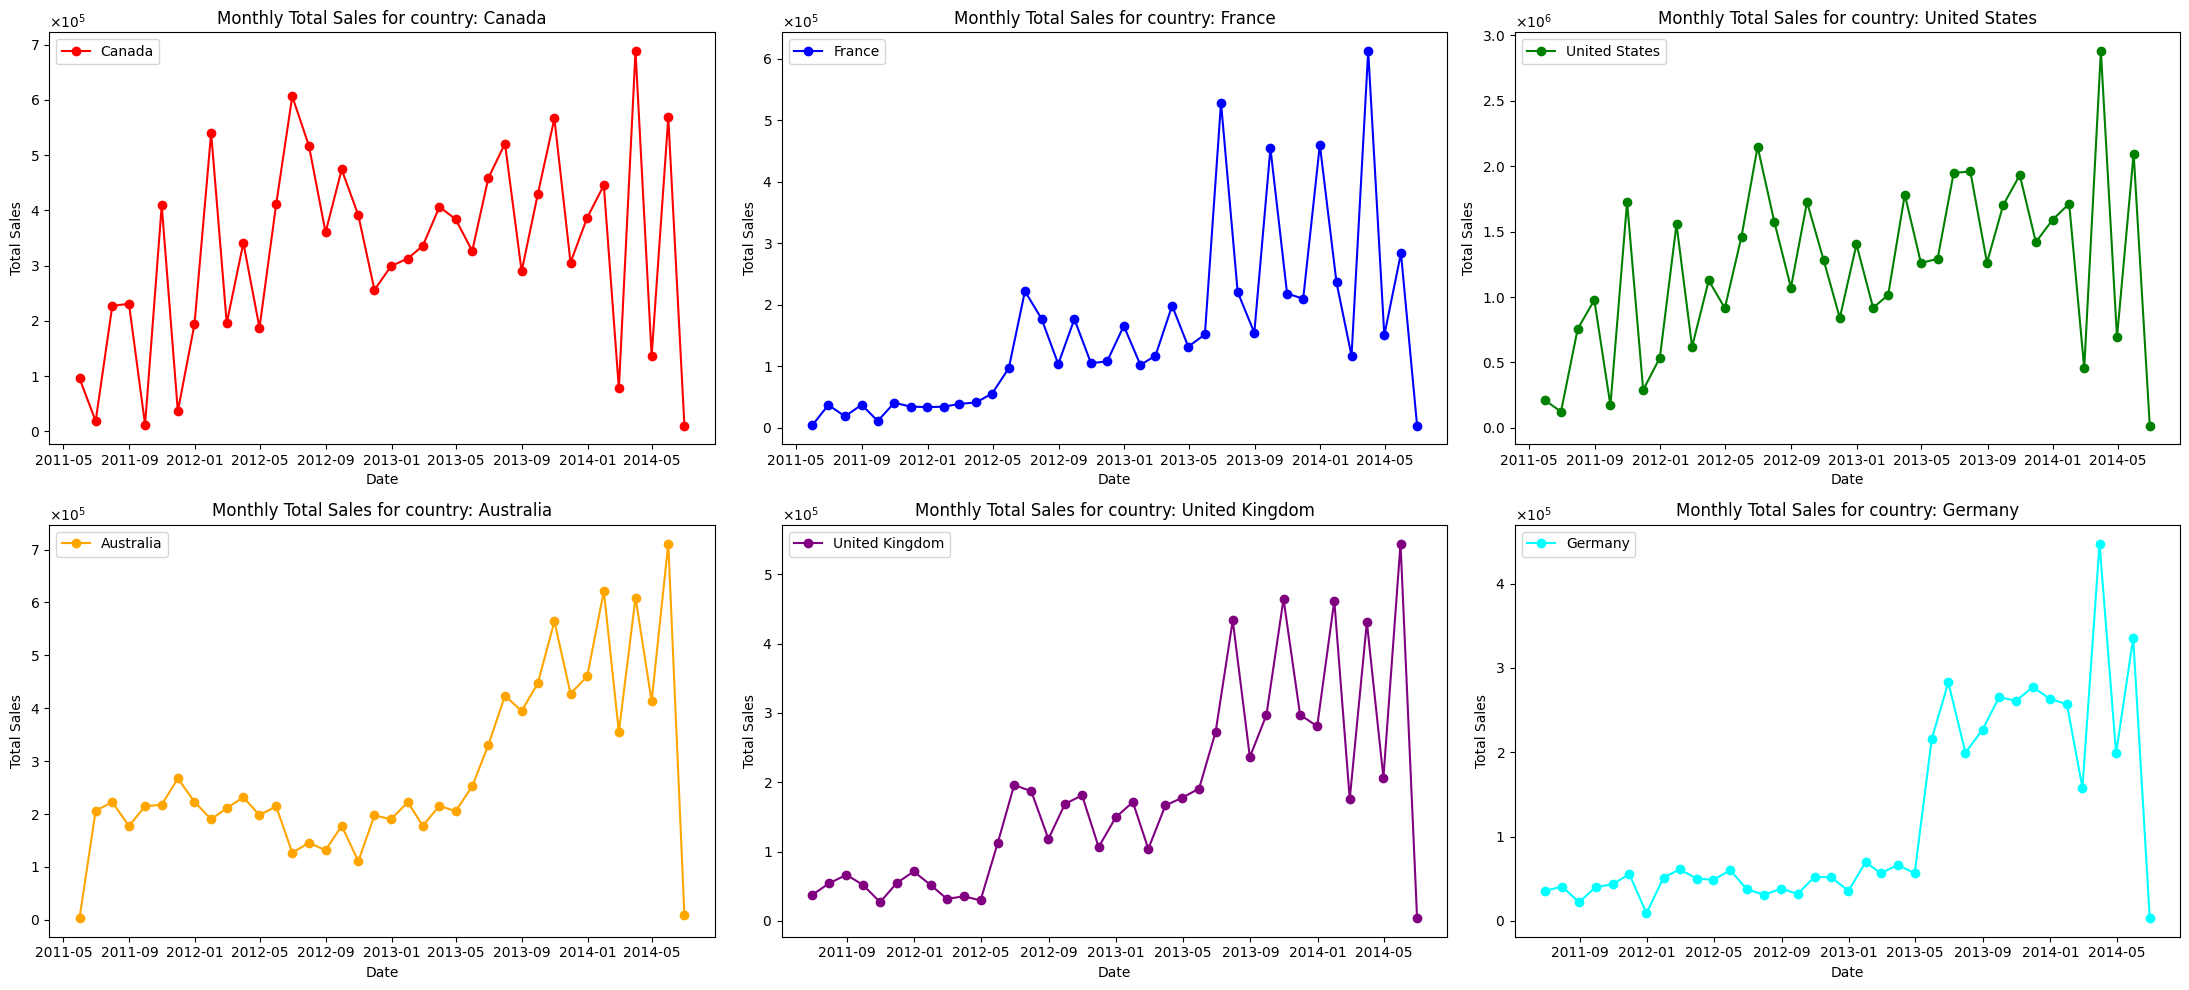

In [87]:
# Extended color palette
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']  # Added 'purple' and 'cyan'

n_countries = len(combined_data)  # Total number of countries
rows, cols = 2, 3  # 2x3 grid for up to 6 countries

fig, axes = plt.subplots(rows, cols, figsize=(22, 10))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, (country, monthly_sales) in enumerate(combined_data.items()):
    ax = axes[i]
    ax.plot(monthly_sales, marker='o', linestyle='-', color=colors[i], label=country)
    ax.set_title(f"Monthly Total Sales for country: {country}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Total Sales")
    ax.legend(loc='upper left')
    
    # Format the y-axis to scientific notation
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Remove any unused subplots if the number of countries is less than rows * cols
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [88]:
def adf_test(series):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))


# Perform ADF test
for (country, data) in train_data.items():
    print(f'{country}')
    adf_test(data)

Canada
ADF Statistic: -4.308696337666193
p-value: 0.0004290587244301073
Critical Value (1%): -3.661
Critical Value (5%): -2.961
Critical Value (10%): -2.619
France
ADF Statistic: 0.384949158779835
p-value: 0.9809232855183833
Critical Value (1%): -3.788
Critical Value (5%): -3.013
Critical Value (10%): -2.646
United States
ADF Statistic: -4.244483089848515
p-value: 0.0005535192577610068
Critical Value (1%): -3.661
Critical Value (5%): -2.961
Critical Value (10%): -2.619
Australia
ADF Statistic: -0.34940651759328095
p-value: 0.9182095599657245
Critical Value (1%): -3.670
Critical Value (5%): -2.964
Critical Value (10%): -2.621
United Kingdom
ADF Statistic: 0.7284207423297886
p-value: 0.9903883181461013
Critical Value (1%): -3.770
Critical Value (5%): -3.005
Critical Value (10%): -2.643
Germany
ADF Statistic: -0.56003461255007
p-value: 0.8797593037512332
Critical Value (1%): -3.670
Critical Value (5%): -2.964
Critical Value (10%): -2.621


In [89]:
# Calculate p-value for stationarity check
def calculate_p_value(data):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(data)
    return result[1]

# Make the time series stationary
def make_stationary(combined_data):
    """
    Make each time series in combined_data stationary using differencing.
    """
    differencing_info = {}  # Store number of differences for each country
    stationary_combined_data = {}

    for country, series in combined_data.items():
        print(f"\nProcessing country: {country}")

        # Initialize differencing count and check for stationarity
        differences = 0
        p_value = calculate_p_value(series)
        current_series = series

        # Apply differencing until stationary
        while p_value > 0.05:
            current_series = current_series.diff().dropna()
            differences += 1
            p_value = calculate_p_value(current_series)

        # Store stationary data and differencing information
        stationary_combined_data[country] = current_series
        differencing_info[country] = differences

        print(f"country: {country} - Stationary after {differences} differences.")

    return stationary_combined_data, differencing_info

# Split the stationary combined data into train and test
def split_train_test(combined_data, test_size=6):
    """
    Split combined_data into train and test sets.
    Test set contains the last `test_size` values of each series.
    """
    train_data = {}
    test_data = {}

    for country, series in combined_data.items():
        # Ensure the series has enough data to split
        if len(series) > test_size:
            train_data[country] = series.iloc[:-test_size]
            test_data[country] = series.iloc[-test_size:]
        else:
            print(f"Warning: Not enough data to split for country {country}")

    return train_data, test_data

# Usage example
stationary_combined_data, differencing_info = make_stationary(combined_data)
stationary_train_data, stationary_test_data = split_train_test(stationary_combined_data)


Processing country: Canada
country: Canada - Stationary after 0 differences.

Processing country: France
country: France - Stationary after 1 differences.

Processing country: United States
country: United States - Stationary after 0 differences.

Processing country: Australia
country: Australia - Stationary after 2 differences.

Processing country: United Kingdom
country: United Kingdom - Stationary after 1 differences.

Processing country: Germany
country: Germany - Stationary after 1 differences.


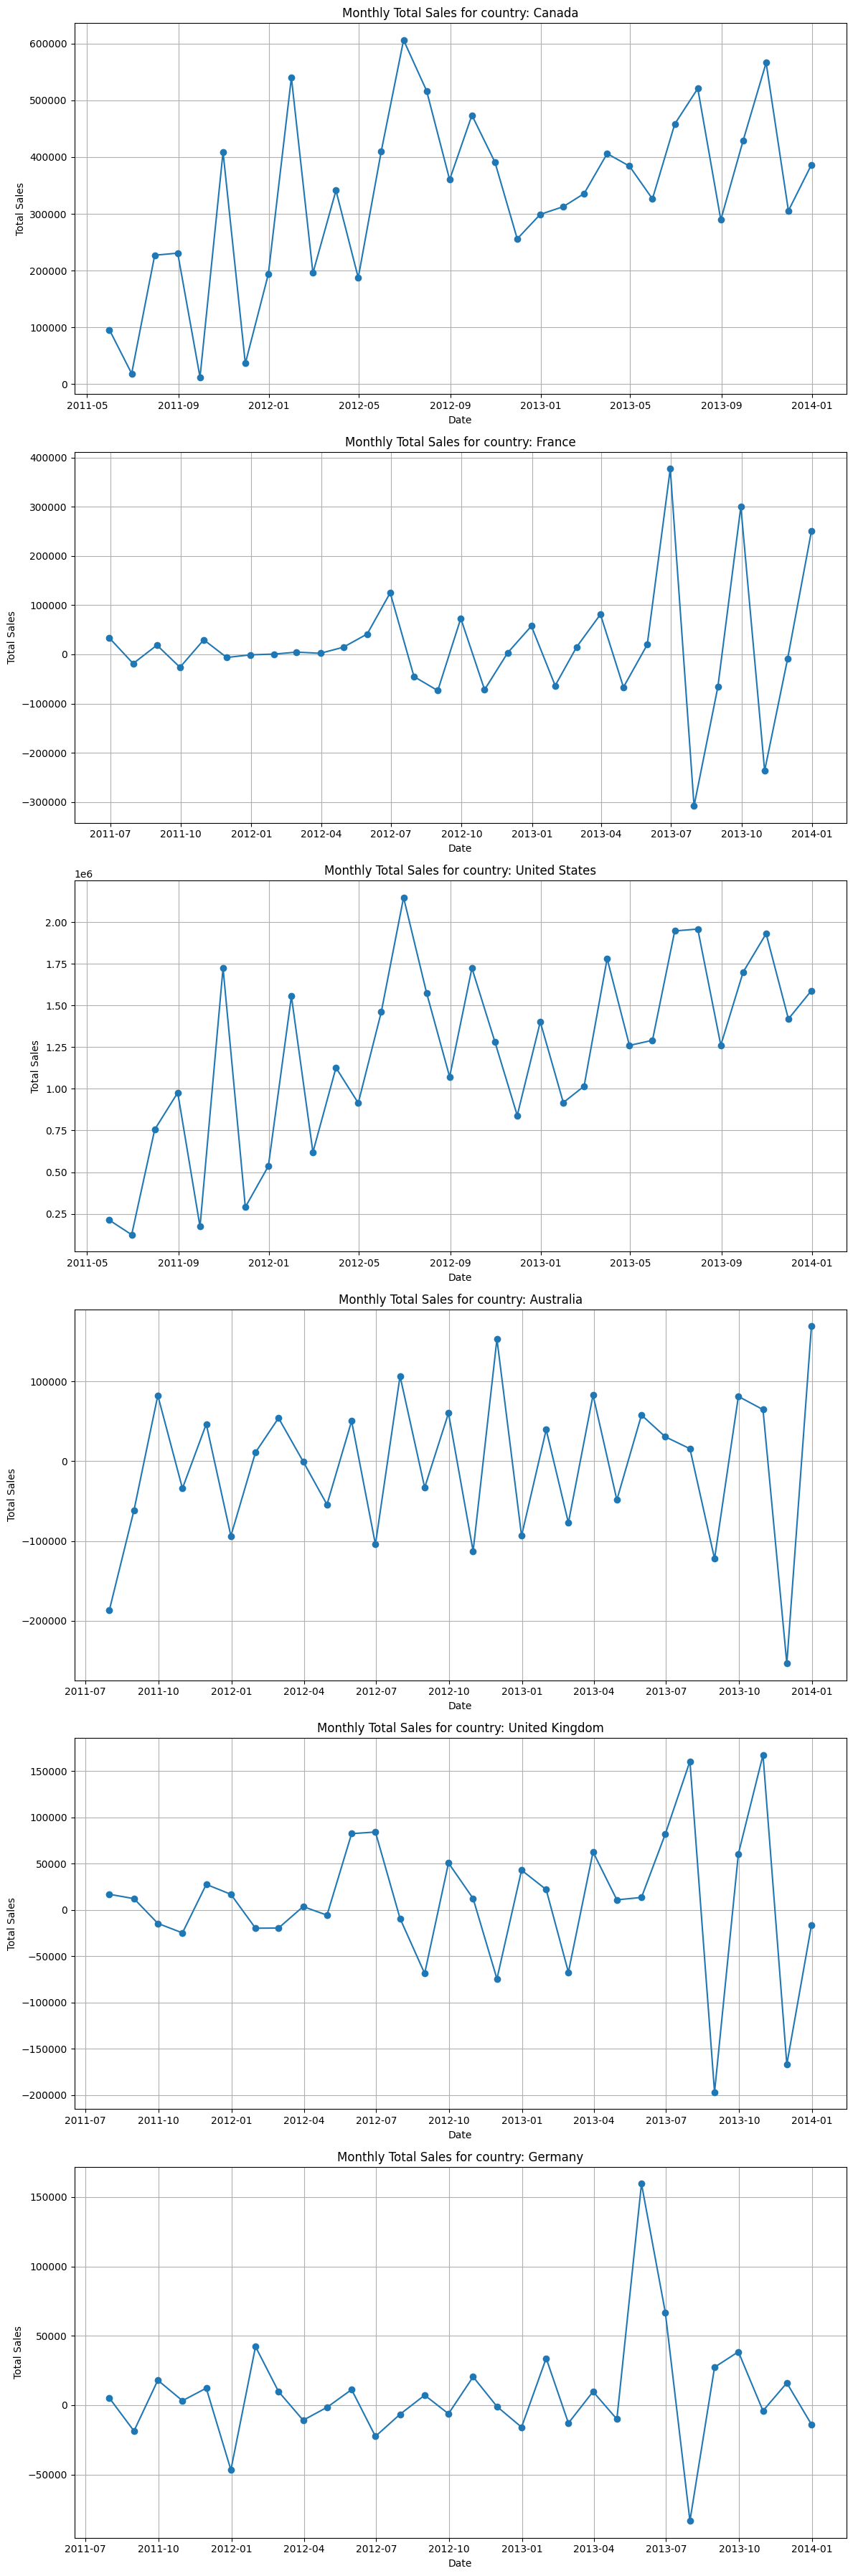

In [90]:
n_countries = len(countries)  # Total number of countries

plt.figure(figsize=(12, 6 * n_countries))  # Adjust figure size dynamically based on the number of countries

for i, (country, monthly_sales) in enumerate(stationary_train_data.items(), 1):
    plt.subplot(n_countries, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for country: {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## ARIMA

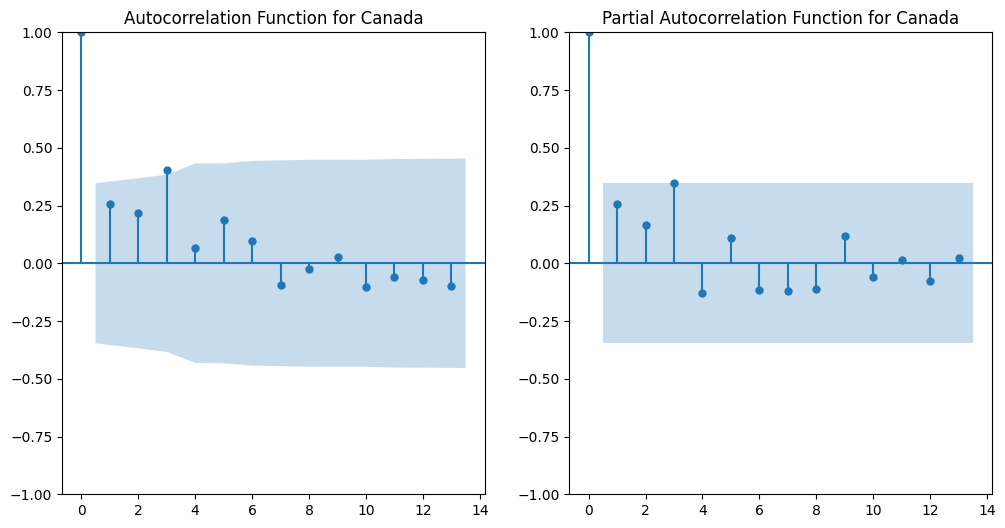

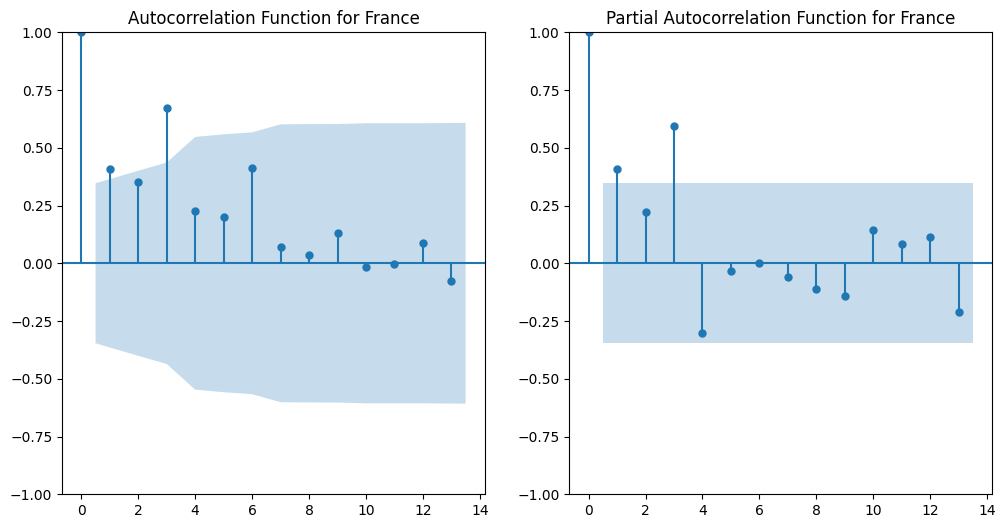

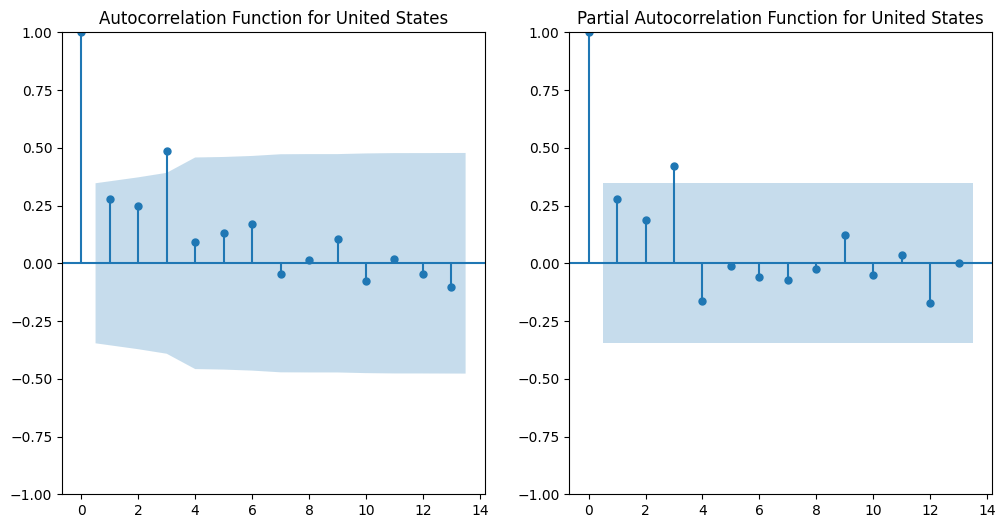

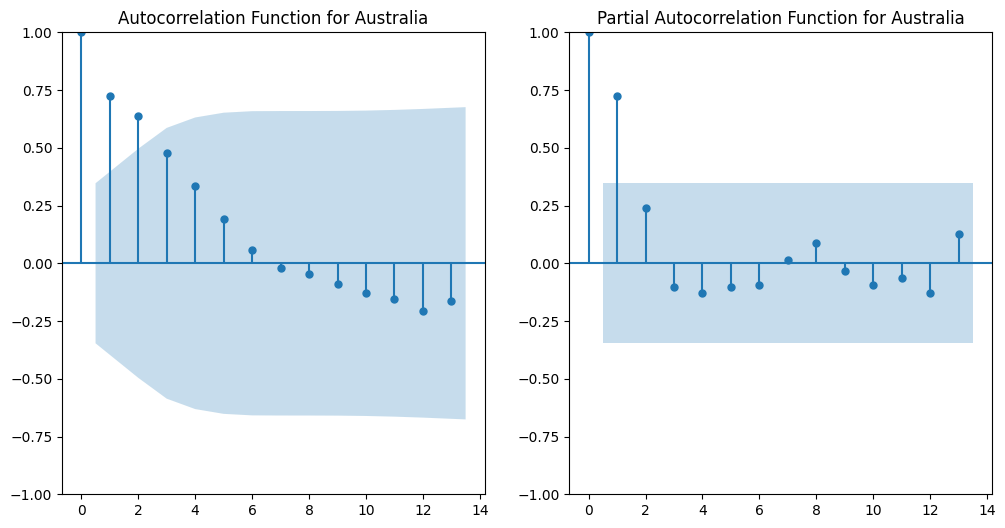

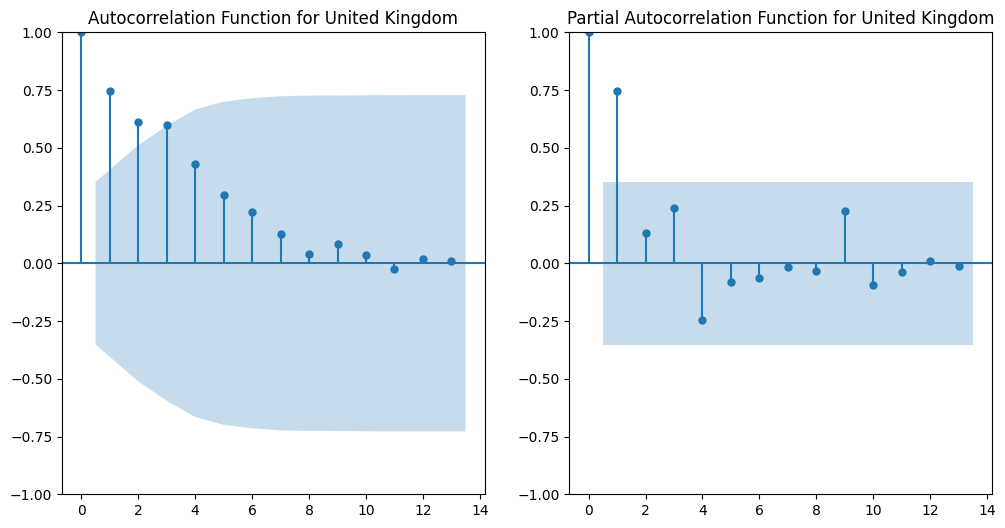

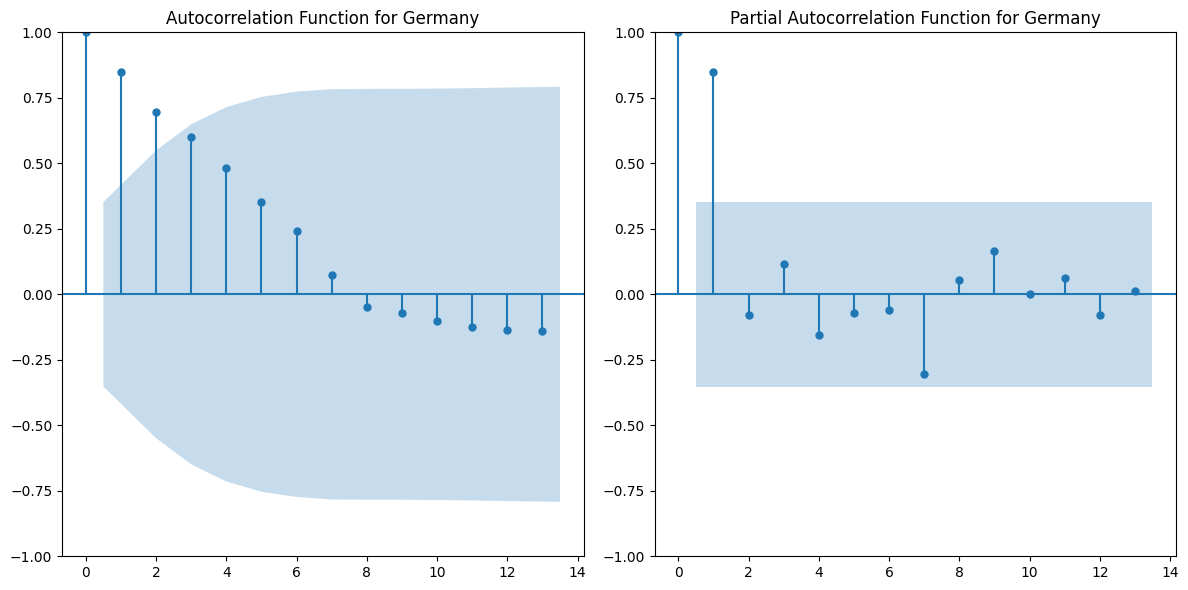

In [91]:
# Define maximum lags (adjust as necessary)
max_lags = 13

# Loop through each country and plot ACF and PACF
for country, monthly_sales in train_data.items():
    plt.figure(figsize=(12, 6))
    
    # Plot ACF
    plt.subplot(121)
    plot_acf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Autocorrelation Function for {country}')
    
    # Plot PACF
    plt.subplot(122)
    plot_pacf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Partial Autocorrelation Function for {country}')
    
plt.tight_layout()
plt.show()

In [92]:
from pmdarima import auto_arima

for country, series in train_data.items():
    print(f"Finding best ARIMA order for {country}...")
    model = auto_arima(series, seasonal=False, trace=True, stepwise=True)
    print(f"Best ARIMA order for {country}: {model.order}")

Finding best ARIMA order for Canada...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=828.701, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=843.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=835.881, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=831.911, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=841.922, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=829.257, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=830.640, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=831.905, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=830.777, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=831.204, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=832.809, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=828.903, Time=0.06 sec

Best model:  AR

In [93]:
countries

['Canada', 'France', 'United States', 'Australia', 'United Kingdom', 'Germany']

In [94]:
model_countries = {}

model_countries[countries[0]] = ARIMA(train_data[countries[0]], order=(10, 0, 10))
model_countries[countries[1]] = ARIMA(train_data[countries[1]], order=(10, 0, 10))
model_countries[countries[2]] = ARIMA(train_data[countries[2]], order=(10, 0, 10))
model_countries[countries[3]] = ARIMA(train_data[countries[3]], order=(10, 0, 10))
model_countries[countries[4]] = ARIMA(train_data[countries[4]], order=(10, 0, 10))
model_countries[countries[5]] = ARIMA(train_data[countries[5]], order=(10, 0, 10))

In [95]:
model_fit_countries = {}

for (country, model) in model_countries.items():
    print(country)
    model_fit_countries[country] = model_countries[country].fit()

Canada


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


France


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


United States


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Australia


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


United Kingdom


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Germany


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [96]:
model_fit_countries.items()

dict_items([('Canada', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000002833BDDBF20>), ('France', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000283629BF620>), ('United States', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000002833BC8B4D0>), ('Australia', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000002833EB16360>), ('United Kingdom', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000002833BC897F0>), ('Germany', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000028362B4BFE0>)])

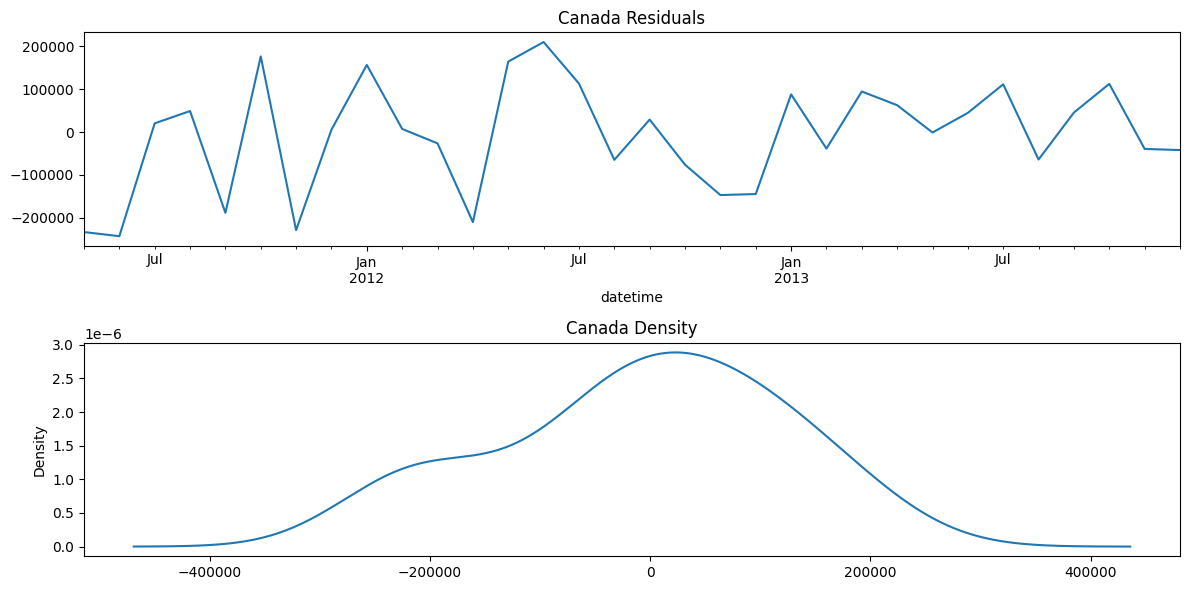

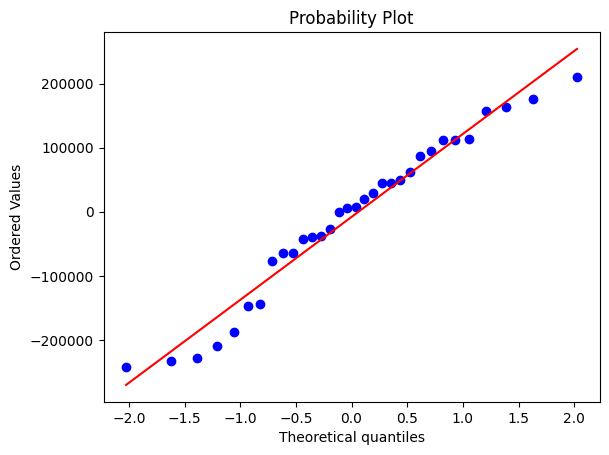

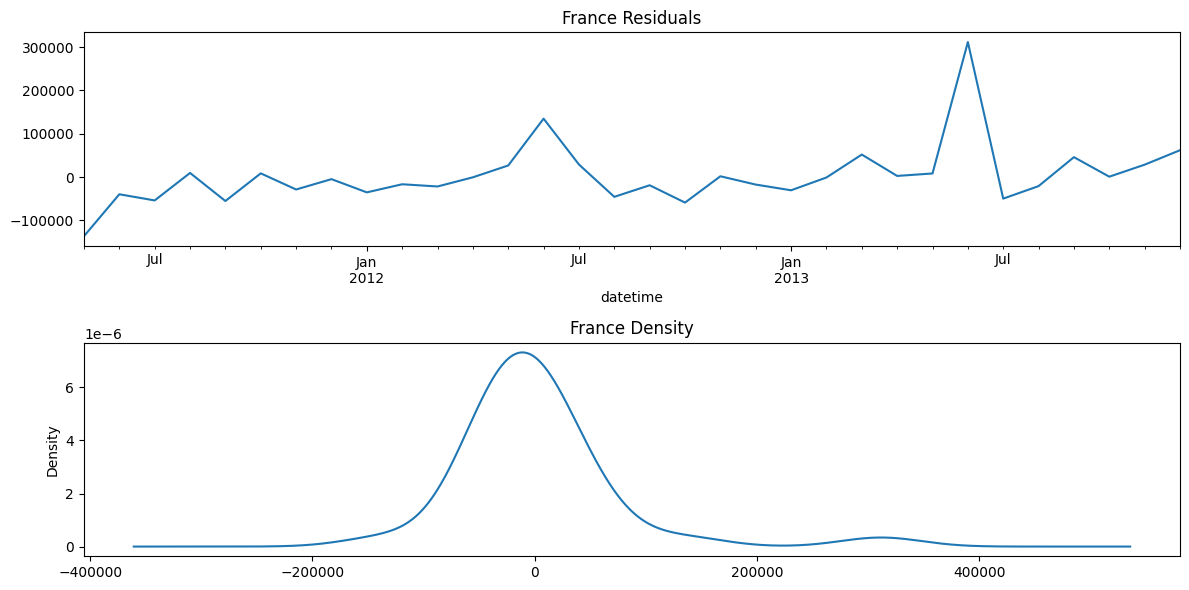

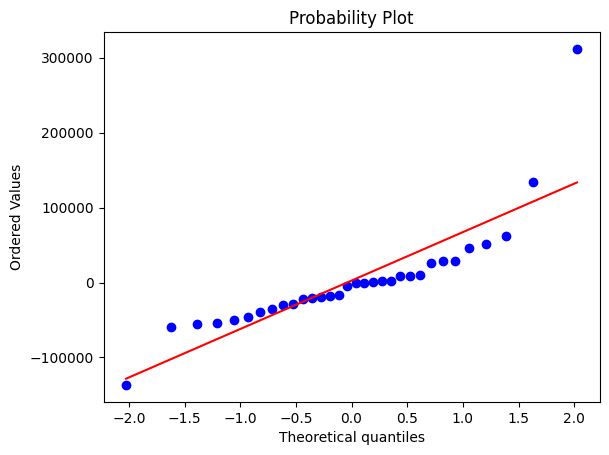

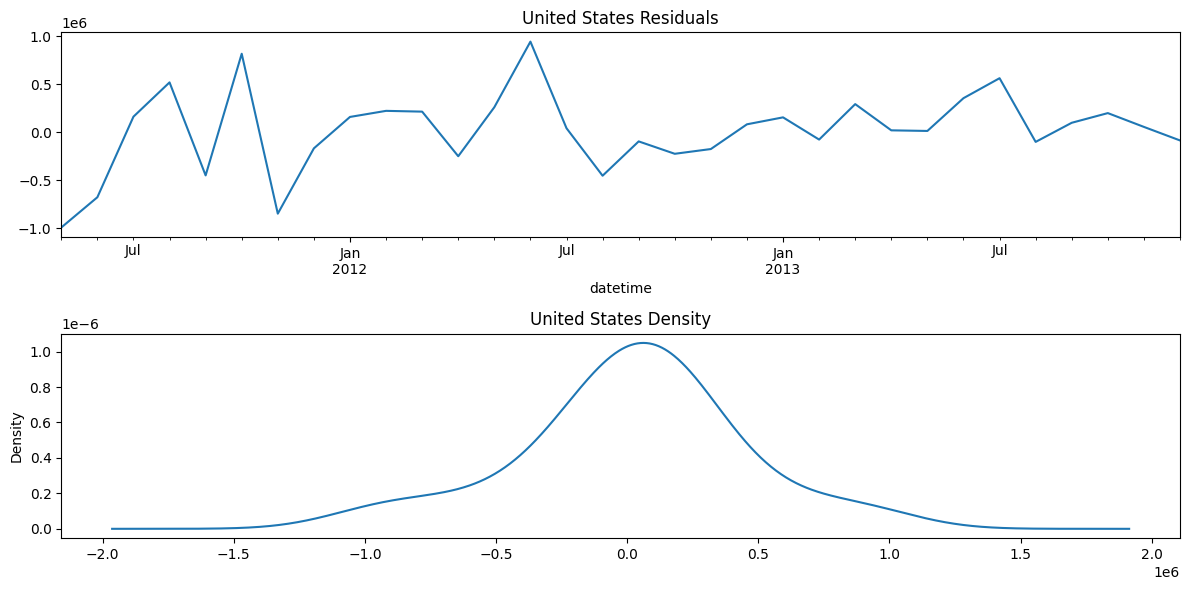

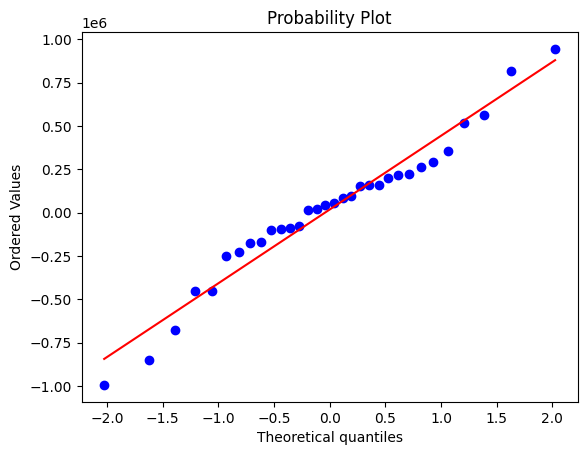

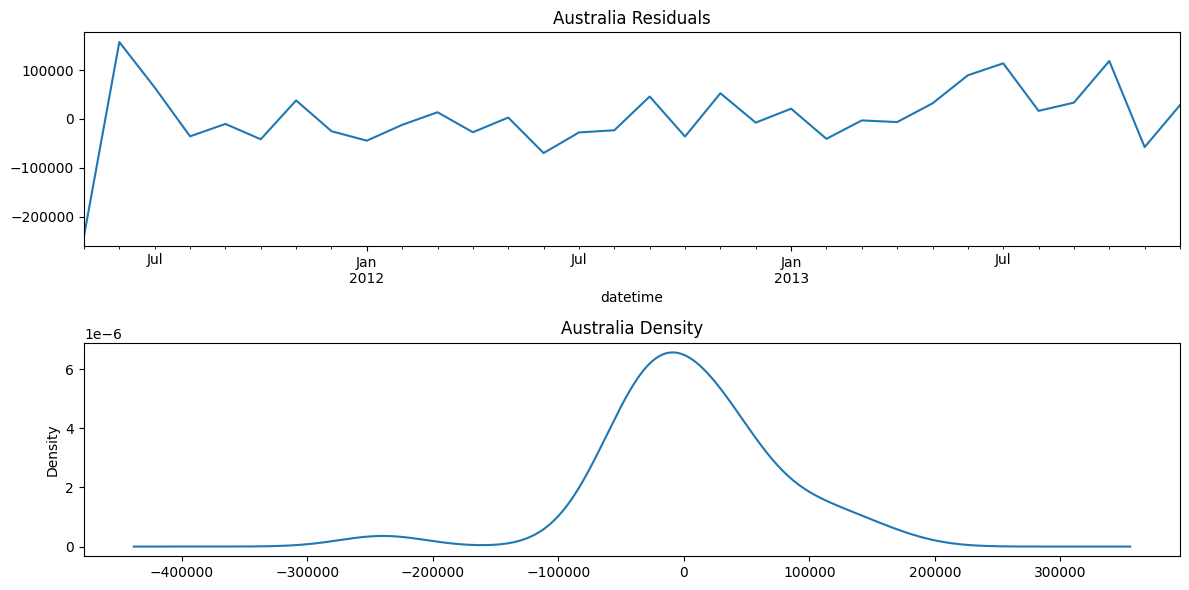

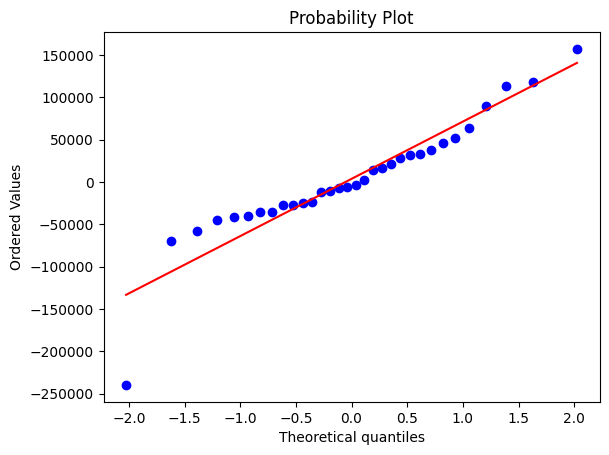

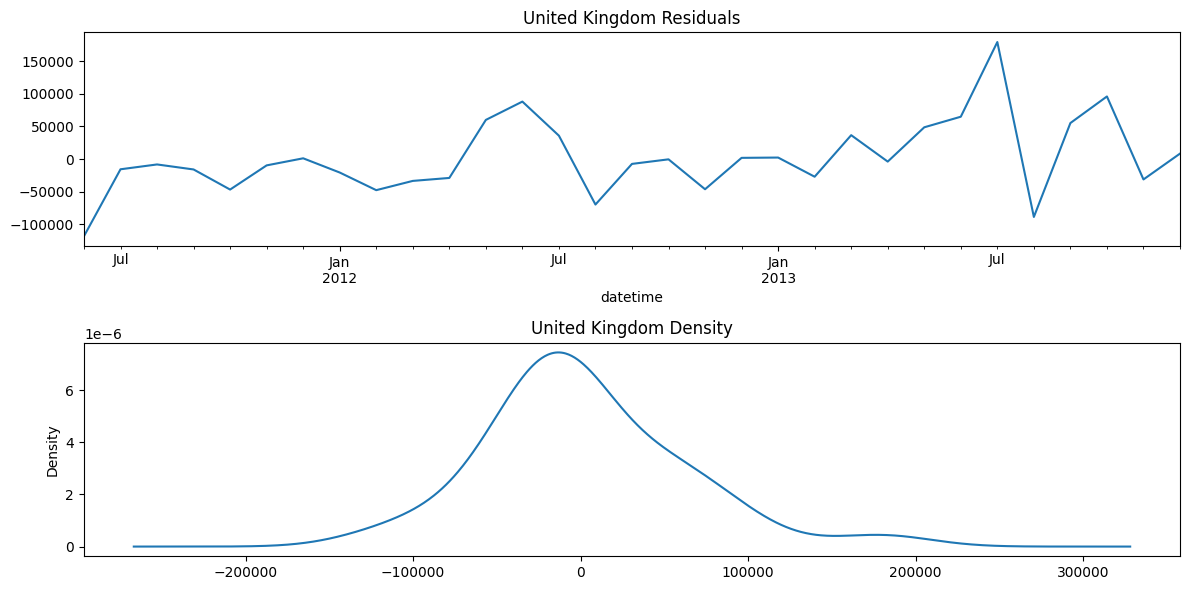

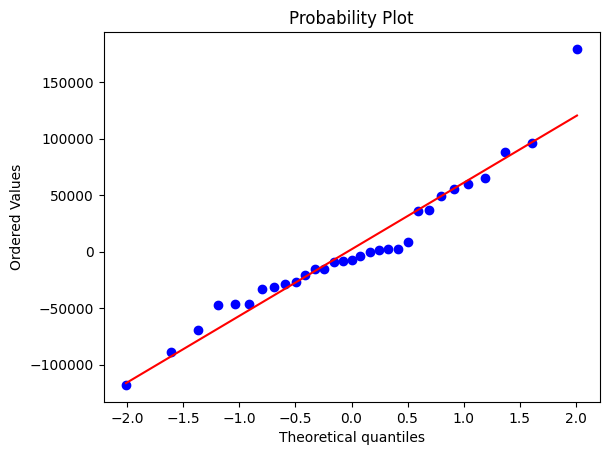

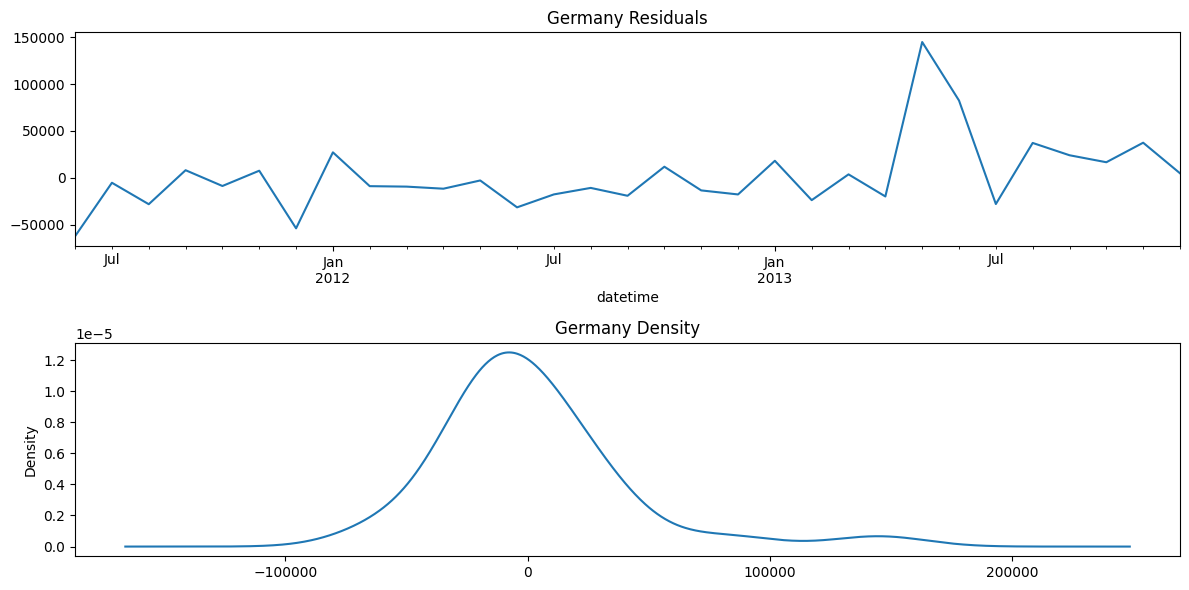

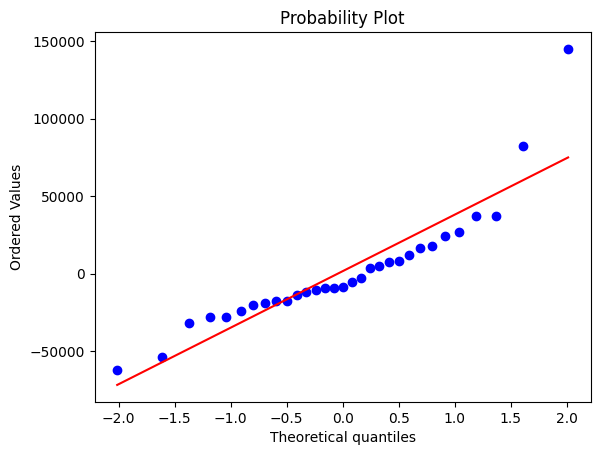

In [97]:
for (country, model) in model_fit_countries.items():
    # Plot residuals
    residuals = model.resid

    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    residuals.plot(title=country + " Residuals", ax=plt.gca())

    plt.subplot(212)
    residuals.plot(kind='kde', title=country + ' Density', ax=plt.gca())

    plt.tight_layout()
    plt.show()

    stats.probplot(residuals, dist="norm", plot=pylab)
    pylab.show()


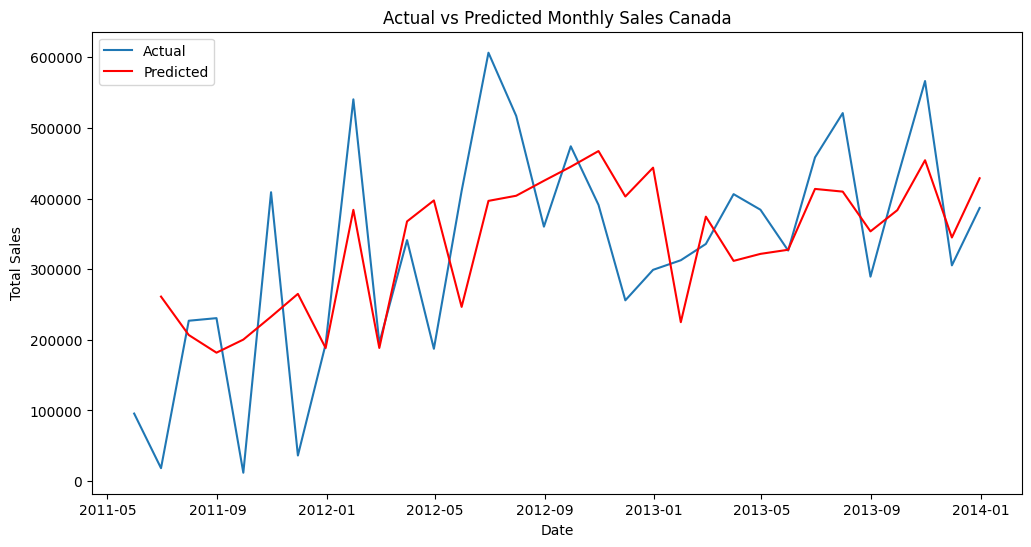

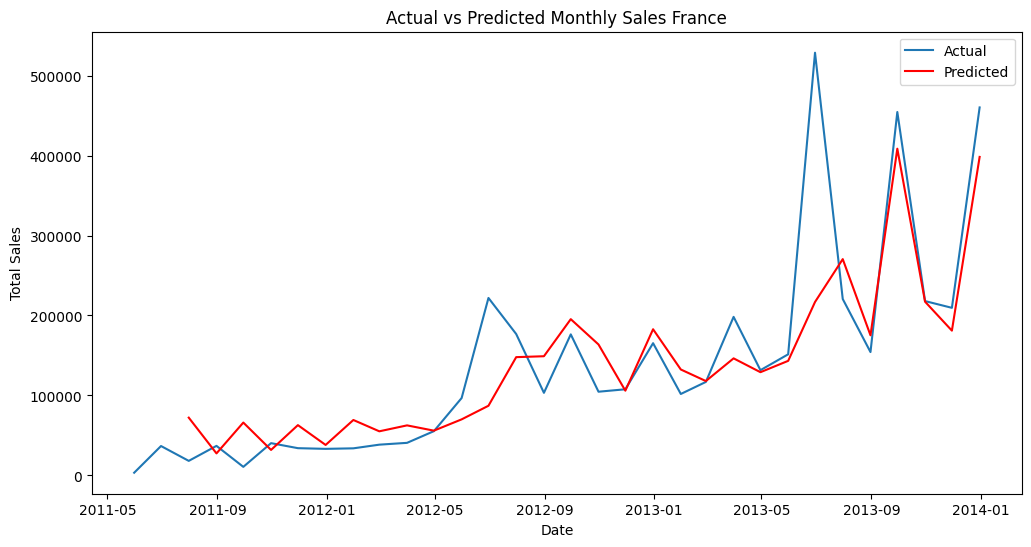

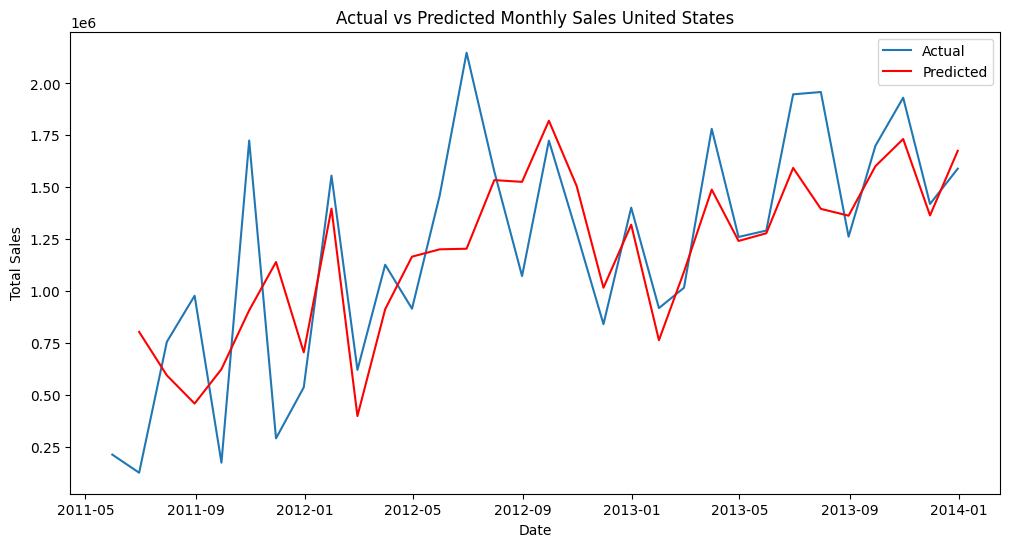

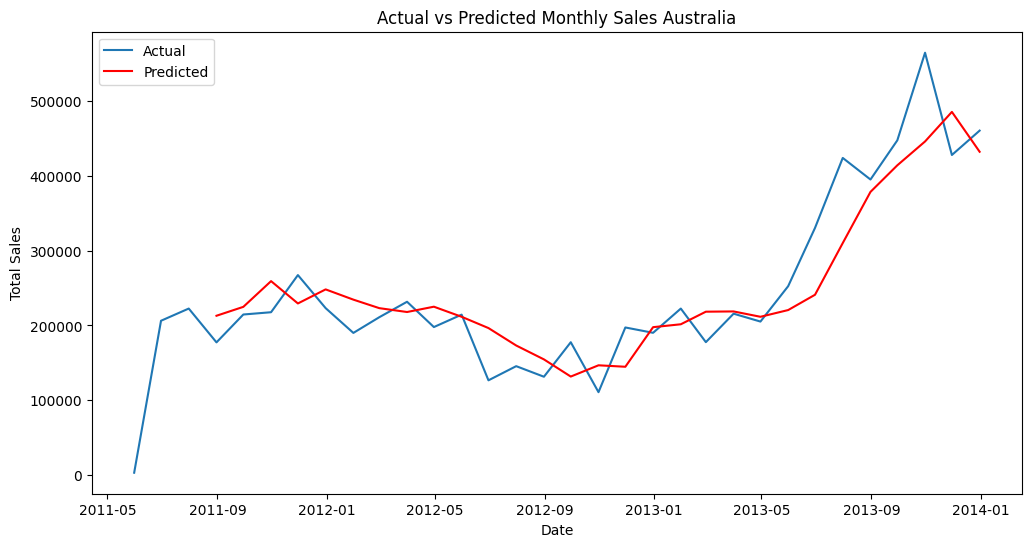

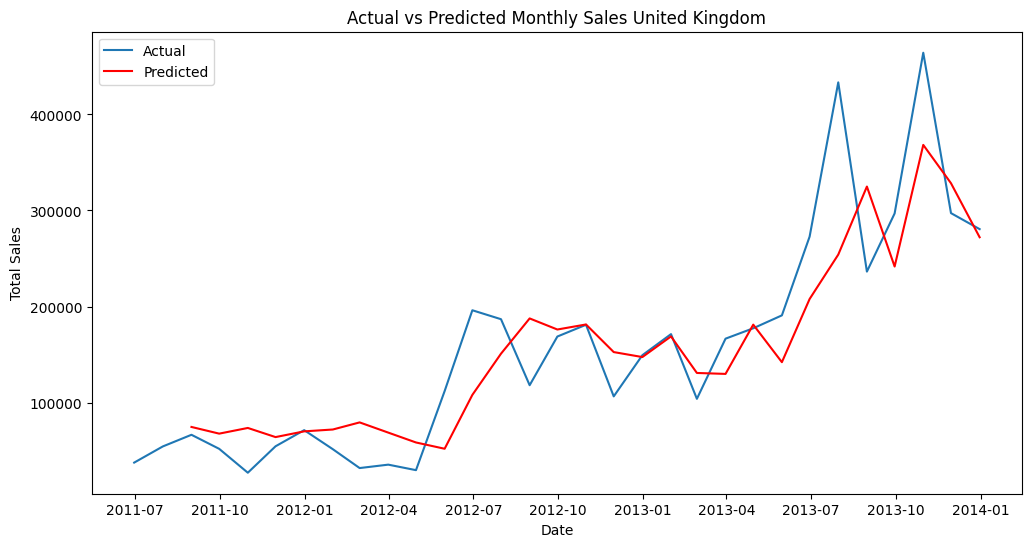

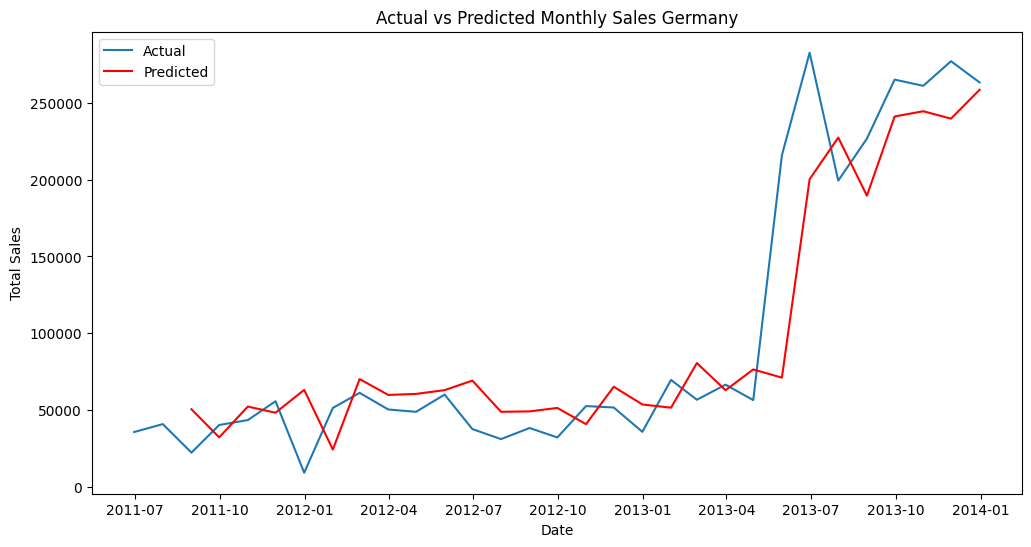

In [98]:
for (country, model) in model_fit_countries.items():
    # In-sample prediction
    predictions = model.predict(start=stationary_train_data[country].index[1], end=stationary_train_data[country].index[-1], typ='levels')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[country], label='Actual')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title('Actual vs Predicted Monthly Sales ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


In [99]:
last_date = train_data[countries[0]].index[-1]
last_date

Timestamp('2013-12-31 00:00:00')

C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\508738288.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


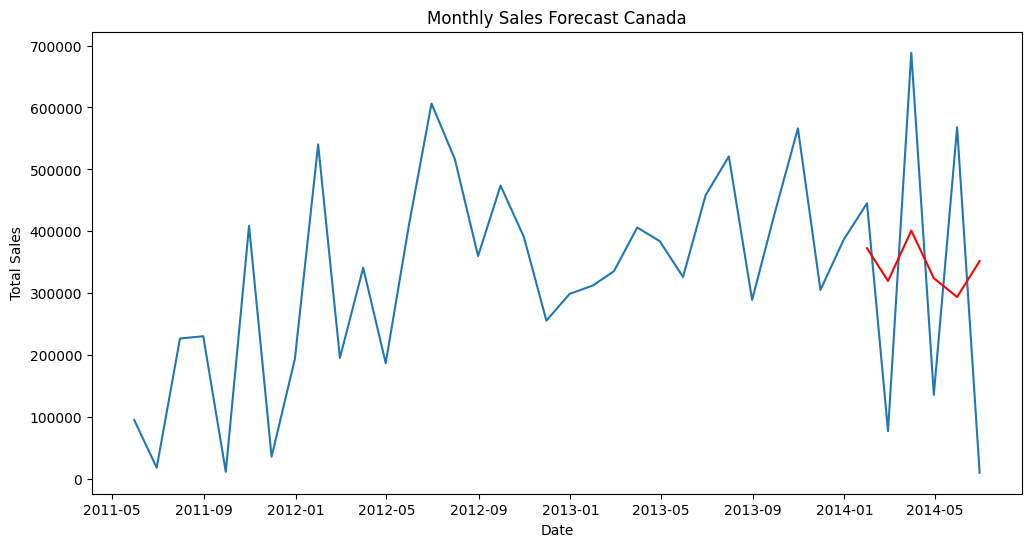

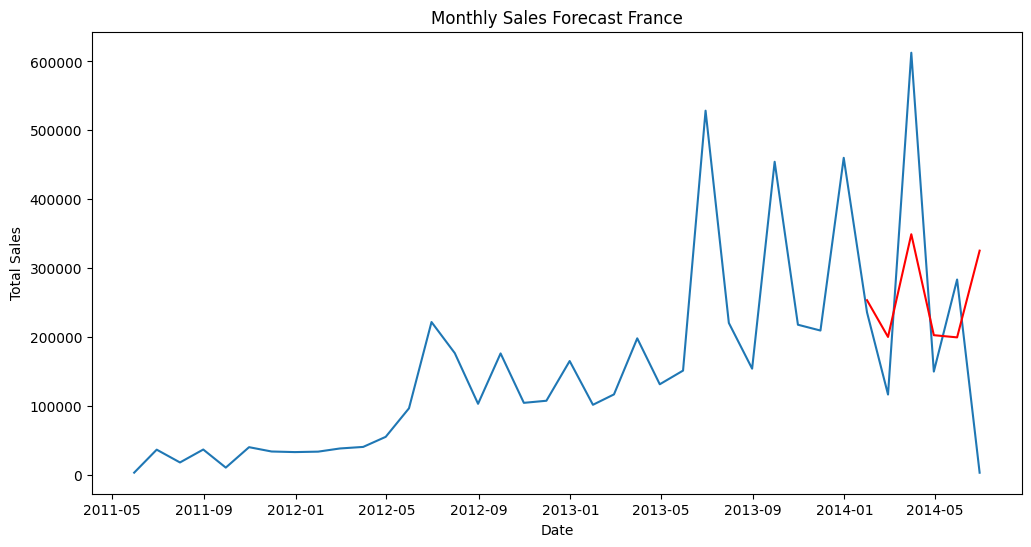

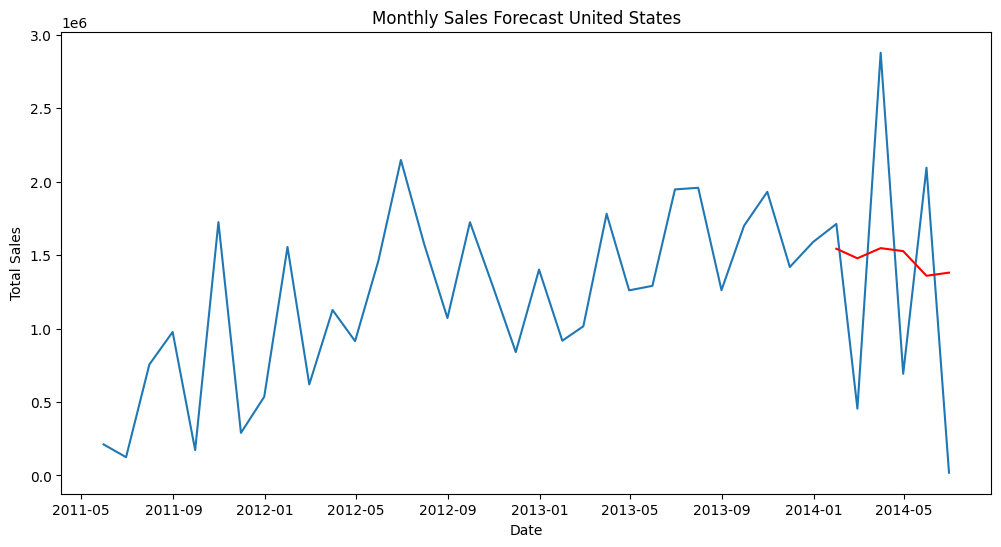

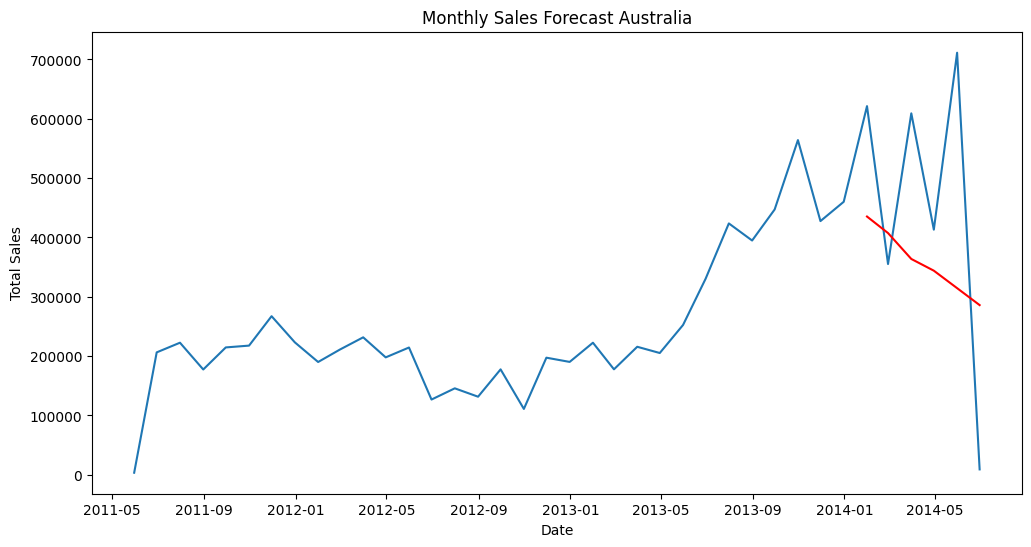

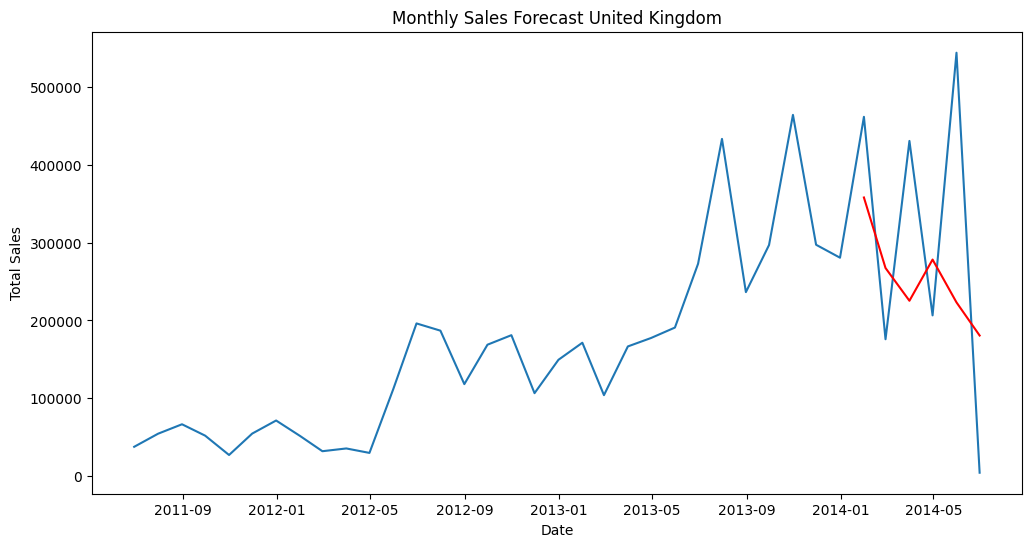

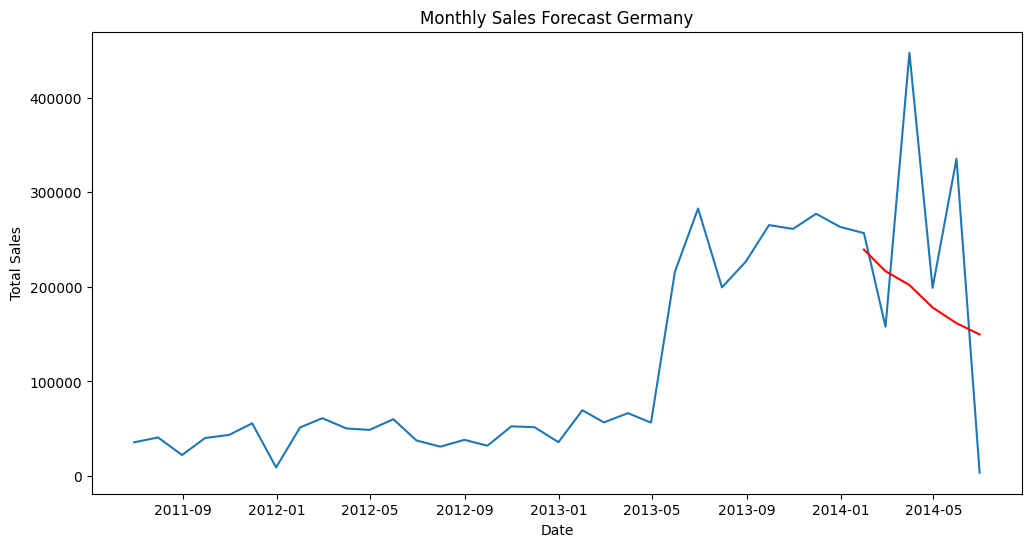

In [100]:
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 6
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')


In [101]:
# for (country, model) in model_fit_countries.items():
#     # Combine historical and forecast data
#     combined = pd.concat([monthly_sales_by_country[country], forecast_series], axis=0)

#     # Plot combined data
#     plt.figure(figsize=(12, 6))
#     plt.plot(combined, label='Combined Data')
#     plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--', label='Forecast Start')
#     plt.title('Historical and Forecasted Sales ' + country)
#     plt.xlabel('Date')
#     plt.ylabel('Total Sales')
#     plt.legend()
#     plt.show()


## SARIMA (no significant seasonality was detected in the data.)

In [102]:
from pmdarima import auto_arima

for country, series in train_data.items():
    print(f"Finding best ARIMA order for {country}...")
    model = auto_arima(series, seasonal=True, trace=True, stepwise=True)
    print(f"Best ARIMA order for {country}: {model.order}")

Finding best ARIMA order for Canada...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=828.701, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=843.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=835.881, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=831.911, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=841.922, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=829.257, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=830.640, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=831.905, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=830.777, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=831.204, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=832.809, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=828.903, Time=0.06 sec

Best model:  AR

## Machine Learning

In [103]:
# Resample 'LineTotal' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country(sales_data_country)

In [104]:
combined_data.keys()

dict_keys(['Canada', 'France', 'United States', 'Australia', 'United Kingdom', 'Germany'])

In [105]:
def add_lag(data, lags=3):
    lagged_data = {}  # To store the lagged DataFrames

    for country, series in data.items():
        print(f"Processing country: {country}")
        
        # Convert Series to DataFrame
        df = series.to_frame(name='sales')  # 'sales' becomes the column name
        
        # Add lag features
        for lag in range(1, lags + 1):
            df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
        
        # Drop NaN rows caused by lagging
        df = df.dropna()

        # Save the processed DataFrame
        lagged_data[country] = df
        
        # Display first rows for validation
        print(type(lagged_data[country]))
        
    
    return lagged_data

In [106]:
lagged_combined_data = add_lag(combined_data, 3)

Processing country: Canada
<class 'pandas.core.frame.DataFrame'>
Processing country: France
<class 'pandas.core.frame.DataFrame'>
Processing country: United States
<class 'pandas.core.frame.DataFrame'>
Processing country: Australia
<class 'pandas.core.frame.DataFrame'>
Processing country: United Kingdom
<class 'pandas.core.frame.DataFrame'>
Processing country: Germany
<class 'pandas.core.frame.DataFrame'>


In [107]:
def split_data(lagged_combined_data):
    lagged_train_data = {}
    lagged_test_data = {}
    
    for country, data in lagged_combined_data.items():
        lagged_train_data[country], lagged_test_data[country] = data[:-6], data[-6:]
        print(type(data))
        
    return lagged_train_data, lagged_test_data

In [108]:
lagged_train_data, lagged_test_data = split_data(lagged_combined_data)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [109]:
lagged_train_data

{'Canada':                   sales  sales_lag_1  sales_lag_2  sales_lag_3
 datetime                                                      
 2011-08-31  230723.1560  227046.2522   18387.1682   95655.0397
 2011-09-30   11929.7264  230723.1560  227046.2522   18387.1682
 2011-10-31  408931.9592   11929.7264  230723.1560  227046.2522
 2011-11-30   36278.5182  408931.9592   11929.7264  230723.1560
 2011-12-31  193883.2114   36278.5182  408931.9592   11929.7264
 2012-01-31  540411.1094  193883.2114   36278.5182  408931.9592
 2012-02-29  195665.0395  540411.1094  193883.2114   36278.5182
 2012-03-31  341175.2329  195665.0395  540411.1094  193883.2114
 2012-04-30  187343.0273  341175.2329  195665.0395  540411.1094
 2012-05-31  410703.2592  187343.0273  341175.2329  195665.0395
 2012-06-30  606395.3965  410703.2592  187343.0273  341175.2329
 2012-07-31  516949.3122  606395.3965  410703.2592  187343.0273
 2012-08-31  360226.8378  516949.3122  606395.3965  410703.2592
 2012-09-30  473956.7038  3602

In [110]:
print(lagged_test_data.values())

dict_values([                  sales  sales_lag_1  sales_lag_2  sales_lag_3
datetime                                                      
2014-01-31  445319.3277  386650.3960  305425.6094  566337.5012
2014-02-28   77497.2600  445319.3277  386650.3960  305425.6094
2014-03-31  688402.5747   77497.2600  445319.3277  386650.3960
2014-04-30  136178.3100  688402.5747   77497.2600  445319.3277
2014-05-31  568146.7268  136178.3100  688402.5747   77497.2600
2014-06-30   10381.5500  568146.7268  136178.3100  688402.5747,                   sales  sales_lag_1  sales_lag_2  sales_lag_3
datetime                                                      
2014-01-31  236074.4975  460185.7678  209593.9610  218031.3025
2014-02-28  116780.2700  236074.4975  460185.7678  209593.9610
2014-03-31  612672.7890  116780.2700  236074.4975  460185.7678
2014-04-30  150099.8900  612672.7890  116780.2700  236074.4975
2014-05-31  283645.5095  150099.8900  612672.7890  116780.2700
2014-06-30    3313.0100  283645.5095  150

In [111]:
def train_stacking_model(data):
    trained_models = {}
    scalers_X = {}

    for country, df in data.items():
        print(f"Training Stacking model for {country}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features only
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)

        # Initialize base models
        lr = LinearRegression()
        xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

        # Initialize stacking regressor
        stacking_model = StackingRegressor(
            estimators=[
                ('lr', lr),      # Linear Regression
                ('xgb', xgb)     # XGBoost
            ],
            final_estimator=LinearRegression()  # Meta-model
        )

        # Leave-One-Out Cross-Validation (LOOCV)
        loo = LeaveOneOut()
        y_preds = []
        y_actuals = []

        for train_index, test_index in loo.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train and predict with stacking model
            stacking_model.fit(X_train, y_train)
            y_pred = stacking_model.predict(X_test)

            y_preds.append(y_pred[0])
            y_actuals.append(y_test)

        # Compute LOOCV RMSE
        rmse = np.sqrt(mean_squared_error(y_actuals, y_preds))
        print(f"{country} - LOOCV RMSE: {rmse:.2f}")

        # Train on full data
        stacking_model.fit(X_scaled, y)

        # Save model and scaler
        trained_models[country] = stacking_model
        scalers_X[country] = scaler_X

    return trained_models, scalers_X

In [112]:
train_models, scalers_X = train_stacking_model(lagged_train_data)

Training Stacking model for Canada...
Canada - LOOCV RMSE: 167681.58
Training Stacking model for France...
France - LOOCV RMSE: 79787.75
Training Stacking model for United States...
United States - LOOCV RMSE: 481111.84
Training Stacking model for Australia...
Australia - LOOCV RMSE: 66426.66
Training Stacking model for United Kingdom...
United Kingdom - LOOCV RMSE: 76252.23
Training Stacking model for Germany...
Germany - LOOCV RMSE: 57704.88


In [113]:
train_models

{'Canada': StackingRegressor(estimators=[('lr', LinearRegression()),
                               ('xgb',
                                XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             lea

In [114]:
def test_simple_model(trained_models, scalers_X, test_data):
    countries_predict = {}
    
    for country, df in test_data.items():
        print(f"Testing model for {country}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features using the saved scaler
        X_scaled = scalers_X[country].transform(X)

        # Predict
        y_pred = trained_models[country].predict(X_scaled)
        y_pred = pd.Series(y_pred, index=df.index)

        # Calculate MSE and RMSE
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        # Print evaluation metrics
        print(f"{country} - Mean Squared Error (MSE): {mse:.2f}")
        print(f"{country} - Root Mean Squared Error (RMSE): {rmse:.2f}\n")
        
        countries_predict[country] = y_pred
        
    return countries_predict

In [115]:
countries_predict = test_simple_model(train_models, scalers_X, lagged_test_data)

Testing model for Canada...
Canada - Mean Squared Error (MSE): 58465713342.78
Canada - Root Mean Squared Error (RMSE): 241796.84

Testing model for France...
France - Mean Squared Error (MSE): 72048716668.00
France - Root Mean Squared Error (RMSE): 268418.92

Testing model for United States...
United States - Mean Squared Error (MSE): 1029882818758.76
United States - Root Mean Squared Error (RMSE): 1014831.42

Testing model for Australia...
Australia - Mean Squared Error (MSE): 81592896394.74
Australia - Root Mean Squared Error (RMSE): 285644.70

Testing model for United Kingdom...
United Kingdom - Mean Squared Error (MSE): 58244597996.33
United Kingdom - Root Mean Squared Error (RMSE): 241339.18

Testing model for Germany...
Germany - Mean Squared Error (MSE): 42001929219.07
Germany - Root Mean Squared Error (RMSE): 204943.72



In [116]:
countries_predict

{'Canada': datetime
 2014-01-31    398834.938351
 2014-02-28    293822.272890
 2014-03-31    367289.046569
 2014-04-30    305329.080531
 2014-05-31    364008.837962
 2014-06-30    368765.159589
 Freq: ME, dtype: float64,
 'France': datetime
 2014-01-31    267862.237247
 2014-02-28    217149.473503
 2014-03-31    373027.494840
 2014-04-30    295907.822132
 2014-05-31    136920.385577
 2014-06-30    569872.610150
 Freq: ME, dtype: float64,
 'United States': datetime
 2014-01-31    1.624342e+06
 2014-02-28    1.426029e+06
 2014-03-31    1.474019e+06
 2014-04-30    1.183174e+06
 2014-05-31    1.172747e+06
 2014-06-30    1.489297e+06
 Freq: ME, dtype: float64,
 'Australia': datetime
 2014-01-31    441600.734983
 2014-02-28    519613.273553
 2014-03-31    423467.735654
 2014-04-30    501246.420882
 2014-05-31    440612.327038
 2014-06-30    569983.600139
 Freq: ME, dtype: float64,
 'United Kingdom': datetime
 2014-01-31    313323.520729
 2014-02-28    239665.097102
 2014-03-31    143838.7330

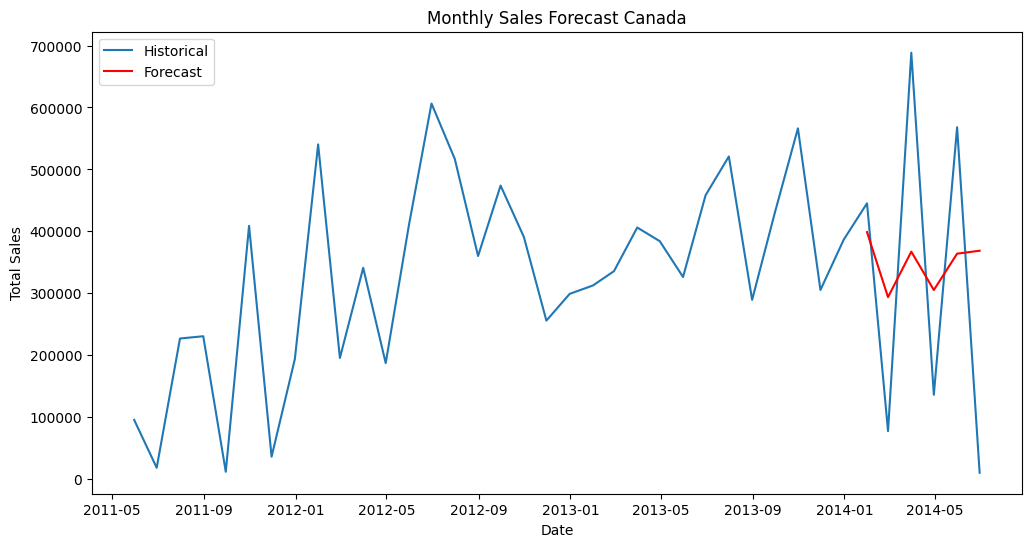

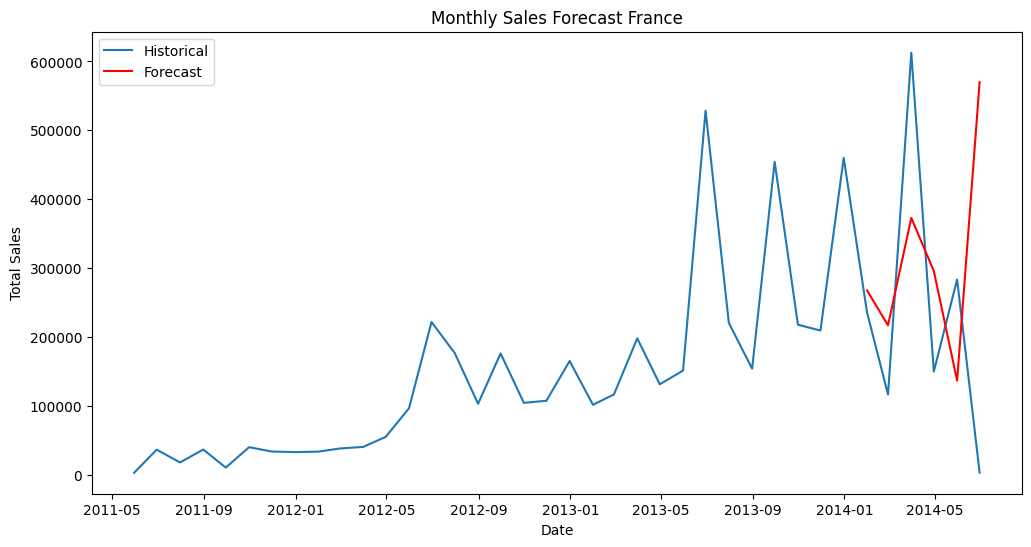

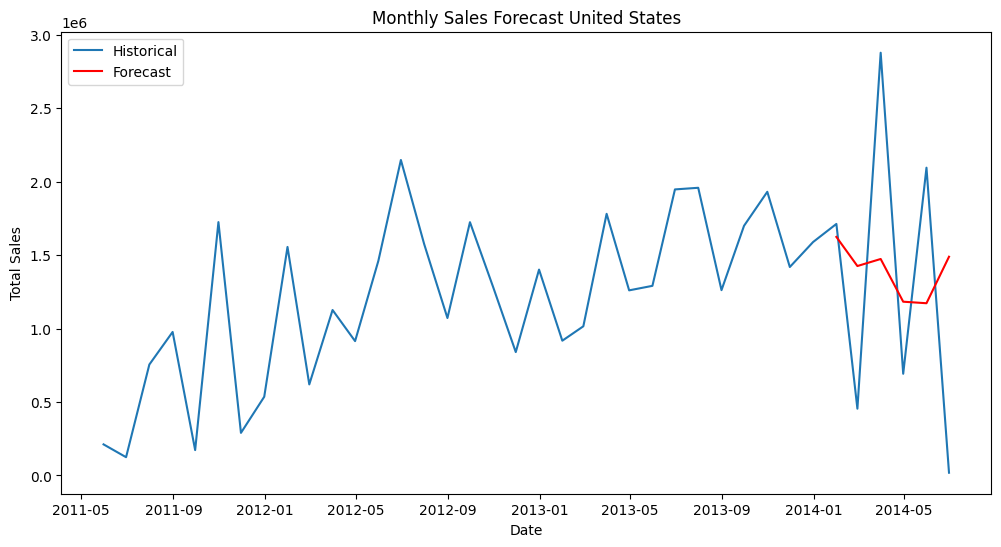

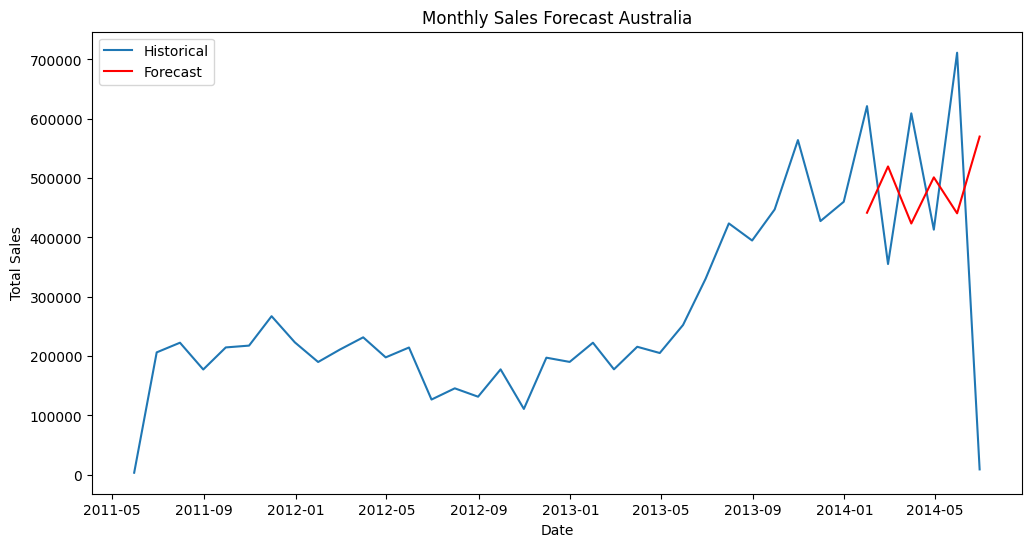

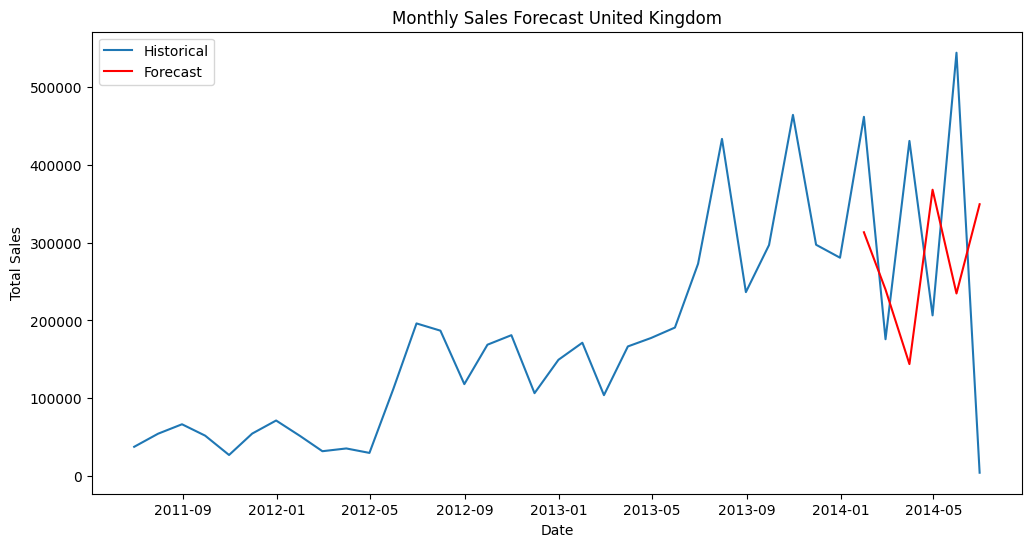

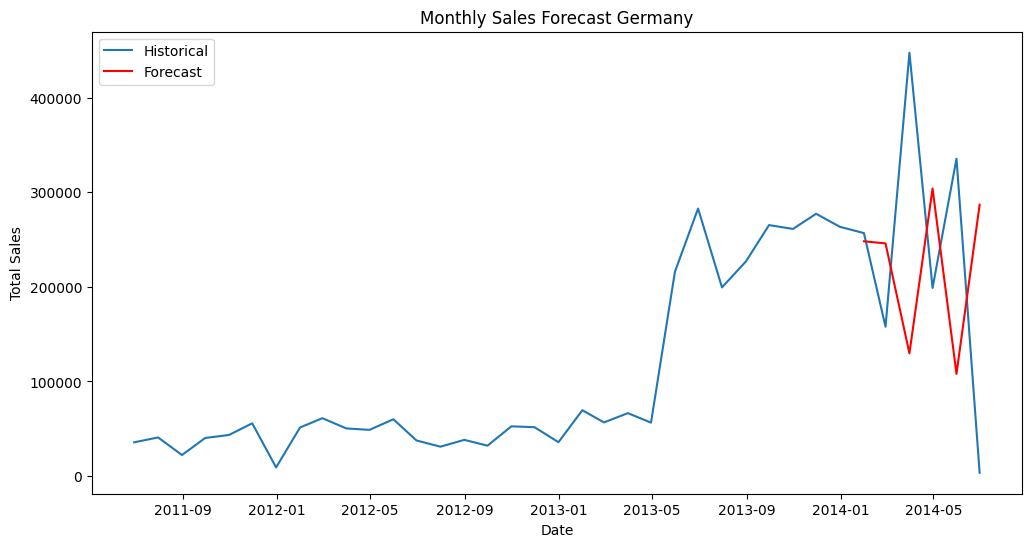

In [117]:
for (country, model) in model_fit_countries.items():

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(countries_predict[country], label='Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()

In [118]:
def forecast_next_months(trained_models, scalers_X, data, months=6):
    future_forecasts = {}

    for country, model in trained_models.items():
        print(f"Forecasting for {country}...")

        # Get the last row of the dataset for lagged features
        last_row = data[country].iloc[-1]
        lag_1, lag_2, lag_3 = last_row['sales_lag_1'], last_row['sales_lag_2'], last_row['sales_lag_3']

        # Start forecasting from the last date in the dataset
        last_date = data[country].index[-1]

        # Generate future dates
        future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]

        # List to store forecasts
        forecasts = []

        for date in future_dates:
            # Create features for the current prediction
            X_new = pd.DataFrame([[lag_1, lag_2, lag_3]], columns=['sales_lag_1', 'sales_lag_2', 'sales_lag_3'])

            # Scale features
            scaler_X = scalers_X[country]
            X_new_scaled = scaler_X.transform(X_new)

            # Predict the next month's sales
            next_sales = model.predict(X_new_scaled)[0]

            # Append prediction to the forecasts
            forecasts.append(next_sales)

            # Update lagged features
            lag_3 = lag_2
            lag_2 = lag_1
            lag_1 = next_sales

        # Convert forecasts to pandas Series with dates as the index
        future_forecasts[country] = pd.Series(data=forecasts, index=future_dates, name='forecast')

    return future_forecasts


In [119]:
future_forecasts = forecast_next_months(train_models, scalers_X, lagged_test_data, 6)
future_forecasts

Forecasting for Canada...
Forecasting for France...
Forecasting for United States...
Forecasting for Australia...
Forecasting for United Kingdom...
Forecasting for Germany...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[

{'Canada': 2014-07-31    368765.159589
 2014-08-31    352697.042932
 2014-09-30    386985.102125
 2014-10-31    358034.985611
 2014-11-30    351634.855342
 2014-12-31    355794.199408
 Freq: ME, Name: forecast, dtype: float64,
 'France': 2014-07-31    569872.610150
 2014-08-31    224035.878231
 2014-09-30    276851.651310
 2014-10-31    544535.491154
 2014-11-30    285075.150149
 2014-12-31    281576.937778
 Freq: ME, Name: forecast, dtype: float64,
 'United States': 2014-07-31    1.489297e+06
 2014-08-31    1.193814e+06
 2014-09-30    1.666622e+06
 2014-10-31    1.505672e+06
 2014-11-30    1.313793e+06
 2014-12-31    1.527385e+06
 Freq: ME, Name: forecast, dtype: float64,
 'Australia': 2014-07-31    569983.600139
 2014-08-31    546928.089559
 2014-09-30    529809.379562
 2014-10-31    505162.165283
 2014-11-30    487008.545715
 2014-12-31    470755.090496
 Freq: ME, Name: forecast, dtype: float64,
 'United Kingdom': 2014-07-31    349351.967574
 2014-08-31    237196.594081
 2014-09-30 

C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\1407805102.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


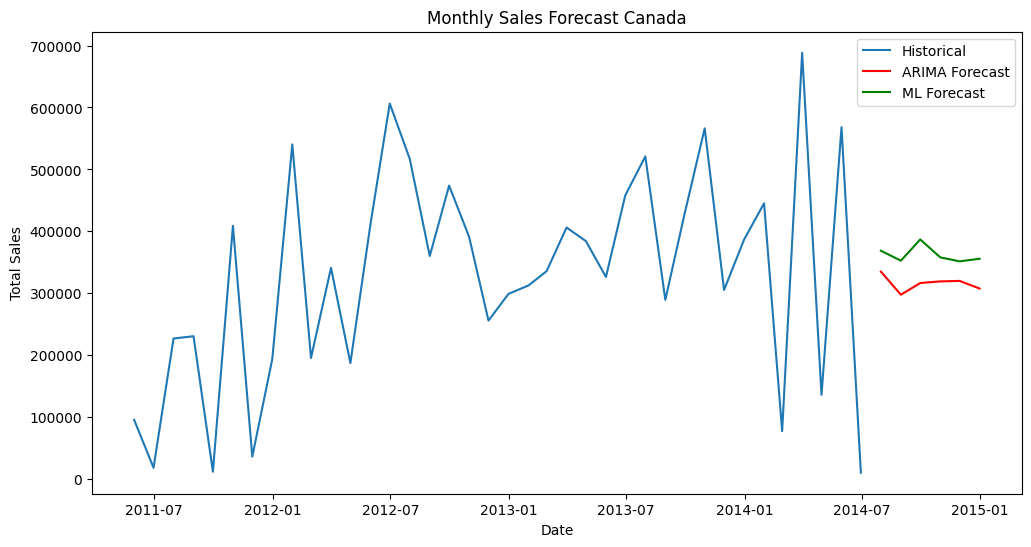

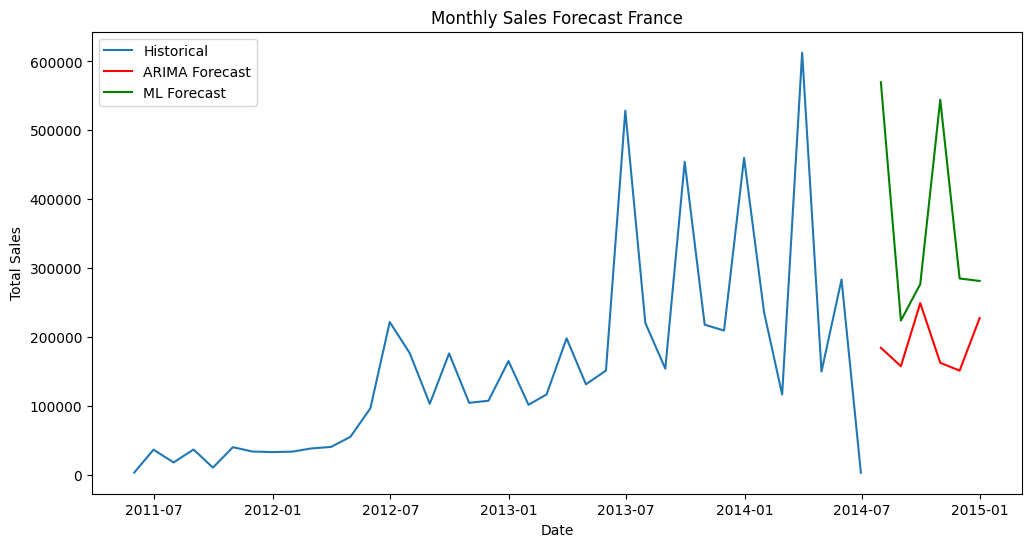

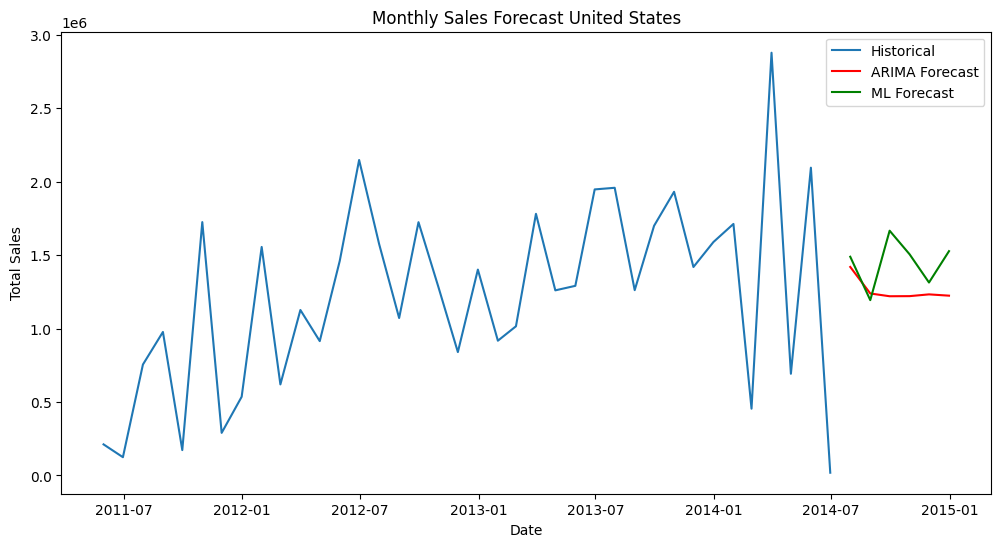

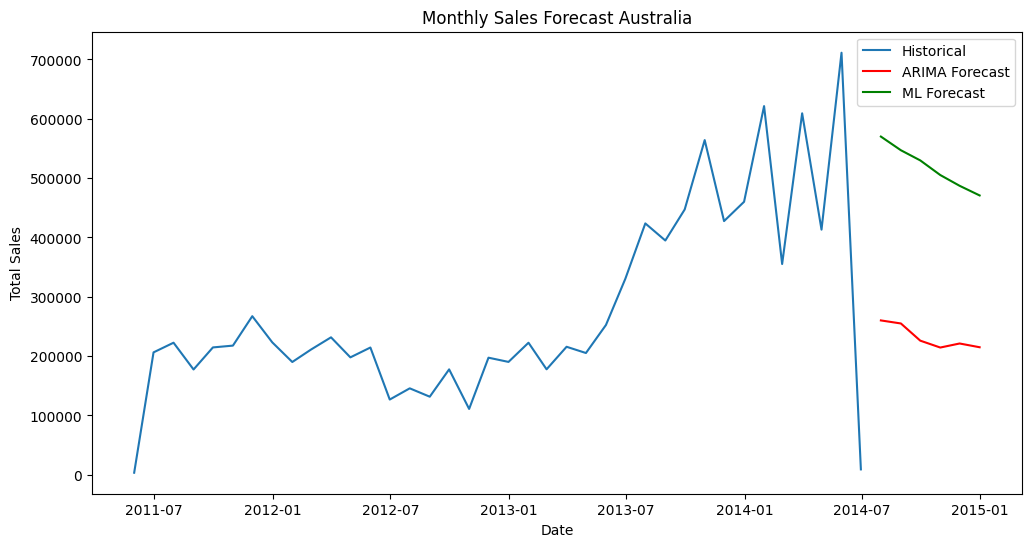

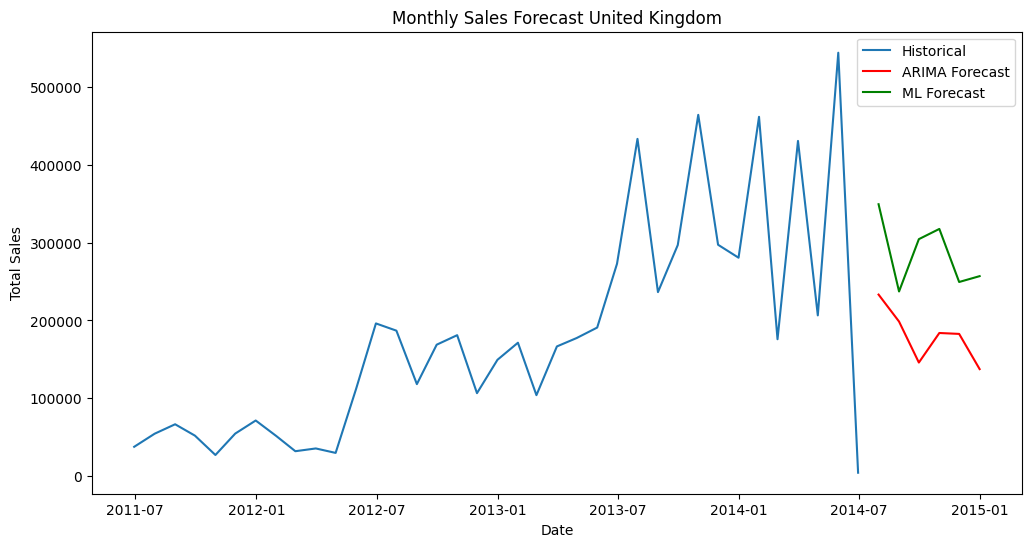

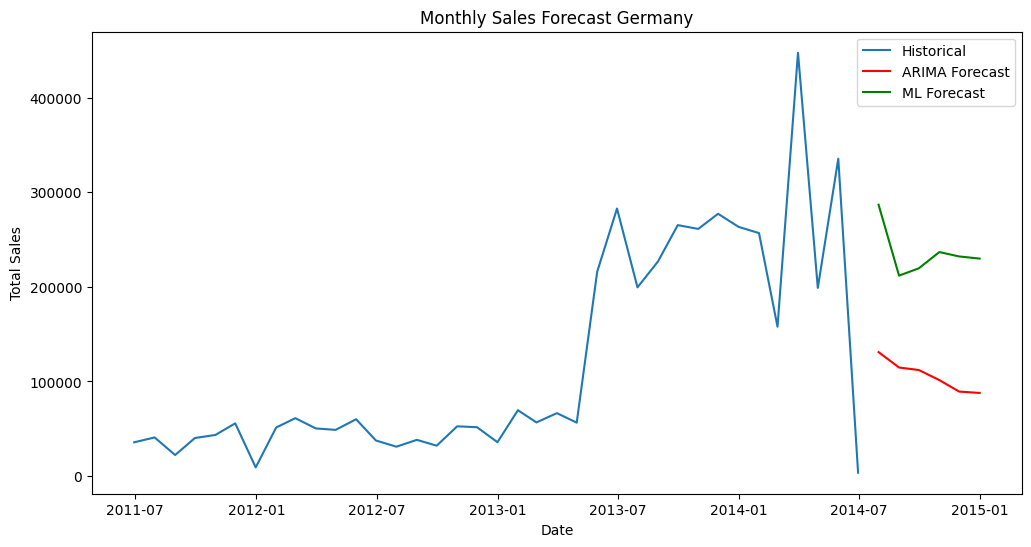

In [120]:
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(future_forecasts[country], label='ML Forecast', color='green')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


## LSTM

In [121]:
def train_test_split_country_lstm(sales_data_country):
    combine_train_test = {
        country: data['LineTotal'].resample('ME').sum() for country, data in sales_data_country.items()
    }
    
    
    train_monthly_sales_by_country = {
        country: data['LineTotal'].resample('ME').sum()[:-6] for country, data in sales_data_country.items()
    }
    
    test_monthly_sales_by_country = {
        country: data['LineTotal'].resample('ME').sum()[-9:] for country, data in sales_data_country.items()
    }
    
    return (combine_train_test, train_monthly_sales_by_country, test_monthly_sales_by_country)

In [122]:
# Resample 'LineTotal' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country_lstm(sales_data_country)

In [123]:
test_data

{'Canada': datetime
 2013-10-31    566337.5012
 2013-11-30    305425.6094
 2013-12-31    386650.3960
 2014-01-31    445319.3277
 2014-02-28     77497.2600
 2014-03-31    688402.5747
 2014-04-30    136178.3100
 2014-05-31    568146.7268
 2014-06-30     10381.5500
 Freq: ME, Name: LineTotal, dtype: float64,
 'France': datetime
 2013-10-31    218031.3025
 2013-11-30    209593.9610
 2013-12-31    460185.7678
 2014-01-31    236074.4975
 2014-02-28    116780.2700
 2014-03-31    612672.7890
 2014-04-30    150099.8900
 2014-05-31    283645.5095
 2014-06-30      3313.0100
 Freq: ME, Name: LineTotal, dtype: float64,
 'United States': datetime
 2013-10-31    1.931507e+06
 2013-11-30    1.419395e+06
 2013-12-31    1.589563e+06
 2014-01-31    1.712674e+06
 2014-02-28    4.546562e+05
 2014-03-31    2.878493e+06
 2014-04-30    6.924442e+05
 2014-05-31    2.095694e+06
 2014-06-30    1.867323e+04
 Freq: ME, Name: LineTotal, dtype: float64,
 'Australia': datetime
 2013-10-31    564042.2786
 2013-11-30  

In [124]:
def train_lstm_with_generator(data, look_back=3, batch_size=4, epochs=50):
    trained_models = {}
    scalers = {}

    for country, df in data.items():
        print(f"Training LSTM model for {country}...")

        # Scale sales data
        df = pd.Series.to_frame(df)
        scaler = MinMaxScaler(feature_range=(0, 1))
        sales_scaled = scaler.fit_transform(df)

        # Use TimeseriesGenerator to create input-output pairs
        generator = TimeseriesGenerator(sales_scaled, sales_scaled, length=look_back, batch_size=batch_size)

        # Build LSTM model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))  # Input shape: (look_back, n_features=1)
        model.add(Dense(1))  # Predict the next step
        model.compile(optimizer='adam', loss='mse')

        # Train the model using generator
        model.fit(generator, epochs=epochs, verbose=1)

        # Save the model and scaler
        trained_models[country] = model
        scalers[country] = scaler

        print(f"{country} - Training completed.")

    return trained_models, scalers

In [125]:
lstm_models, lstm_scalers = train_lstm_with_generator(train_data, look_back=3)

Training LSTM model for Canada...
Epoch 1/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4348
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3428 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2962 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2556 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1744 
Epoch 6/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1039 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0802 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0530 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0542 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0364 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0367 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0355 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0578 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0614 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0454 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0575 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0454 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0562 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1211
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1124 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0911 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2121 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0968 
Epoch 6/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0285

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0476 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1253 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0544 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0956 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0441 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0339 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0321 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0331 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0358 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0393 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0357 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0536 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0368 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0495 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0327 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4620
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3956 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3204 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1943 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1586 
Epoch 6/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1839

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1619 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0971 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0891 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0523 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0393 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0359     
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0434 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0477 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0398 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0362     
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0344 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0637 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0593 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0446 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0459 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1402
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1935 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1211 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0593 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0514 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0327 


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0178 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0294 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0252 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0122 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0187 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0155 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 
Epoch 22/50
8/8 ━━━━━━━━━━━━

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2500
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0759 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1348 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0891 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0626 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0588 


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0662 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0378 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0769 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0391 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0563 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0404 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0453 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0432 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0354 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0362 
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0226 
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0306 
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0358 
Epoch 21/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0205 
Epoch 22/50
7/7 ━━━━━━━━━━━━

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1366  
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2550 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1168 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1620 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1188 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1851 


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0964 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1628 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0461     
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0720 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1850 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0868 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0487 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0296 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0584 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0513 
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0644 
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0650 
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0598 
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0671 
Epoch 21/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0664 
Epoch 22/50
7/7 ━━━━━━━━

In [126]:
def test_lstm_model(trained_models, scalers, test_data, look_back=3):
    predictions = {}

    for country, df in test_data.items():
        print(f"Testing LSTM model for {country}...")
        
        # Save the original index to align predictions later
        original_index = df.index

        # Ensure df is a DataFrame and retain the original index
        if isinstance(df, pd.Series):
            df = pd.Series.to_frame(df)

        # Scale the sales data using the saved scaler
        scaler = scalers[country]
        scaled_data = scaler.transform(df)

        # Ensure look_back does not exceed the available data length
        if len(scaled_data) <= look_back:
            print(f"Not enough data for {country}: reducing look_back to {len(scaled_data) - 1}")
            look_back = len(scaled_data) - 1

        # Prepare input sequences using TimeseriesGenerator
        generator = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=1)

        # Get the trained model
        model = trained_models[country]

        # Make predictions
        y_pred_scaled = []
        for i in range(len(generator)):
            X, _ = generator[i]  # Get input sequence
            y_pred = model.predict(X, verbose=0)  # Predict next step
            y_pred_scaled.append(y_pred[0][0])  # Append prediction

        # Inverse transform predictions back to original scale
        y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).ravel()

        # Align predictions with the correct index
        prediction_index = original_index[-len(y_pred):]
        predictions[country] = pd.Series(y_pred, index=prediction_index)

        print(f"{country} - Testing completed.")

    return predictions


In [127]:
lstm_res = test_lstm_model(lstm_models, lstm_scalers, test_data)

Testing LSTM model for Canada...
Canada - Testing completed.
Testing LSTM model for France...
France - Testing completed.
Testing LSTM model for United States...
United States - Testing completed.
Testing LSTM model for Australia...
Australia - Testing completed.
Testing LSTM model for United Kingdom...
United Kingdom - Testing completed.
Testing LSTM model for Germany...
Germany - Testing completed.


In [128]:
lstm_res

{'Canada': datetime
 2014-01-31    397914.56250
 2014-02-28    358787.09375
 2014-03-31    345646.09375
 2014-04-30    358976.06250
 2014-05-31    325832.25000
 2014-06-30    414759.93750
 Freq: ME, dtype: float32,
 'France': datetime
 2014-01-31    302788.15625
 2014-02-28    349232.31250
 2014-03-31    407300.34375
 2014-04-30    304850.84375
 2014-05-31    324696.71875
 2014-06-30    502021.78125
 Freq: ME, dtype: float32,
 'United States': datetime
 2014-01-31    1603712.625
 2014-02-28    1506204.500
 2014-03-31    1379625.250
 2014-04-30    1511773.000
 2014-05-31    1376109.000
 2014-06-30    1822161.500
 Freq: ME, dtype: float32,
 'Australia': datetime
 2014-01-31    489867.18750
 2014-02-28    496902.31250
 2014-03-31    486932.78125
 2014-04-30    532524.81250
 2014-05-31    458371.40625
 2014-06-30    581993.06250
 Freq: ME, dtype: float32,
 'United Kingdom': datetime
 2014-01-31    379158.8750
 2014-02-28    345746.8750
 2014-03-31    319520.4375
 2014-04-30    372711.2500


In [129]:
def forecast_lstm_model(trained_models, scalers, test_data, look_back=3, forecast_steps=6):
    forecasts = {}

    for country, df in test_data.items():
        print(f"Forecasting next {forecast_steps} months for {country}...")

        # Ensure df is a DataFrame and retain the original index
        if isinstance(df, pd.Series):
            df = pd.Series.to_frame(df)

        # Scale the sales data using the saved scaler
        scaler = scalers[country]
        scaled_data = scaler.transform(df)

        # Start with the last look_back window of scaled data
        last_window = scaled_data[-look_back:].reshape(1, look_back, 1)

        # Initialize list to store predictions
        forecast_scaled = []

        # Get the trained model
        model = trained_models[country]

        # Iteratively predict the next steps
        for step in range(forecast_steps):
            # Predict next value
            next_pred = model.predict(last_window, verbose=0)[0][0]
            forecast_scaled.append(next_pred)

            # Update the input window: remove oldest value, append predicted value
            last_window = np.append(last_window[:, 1:, :], [[[next_pred]]], axis=1)

        # Inverse transform predictions back to original scale
        forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).ravel()

        # Create a date range for the forecast period
        start_date = df.index[-1]  # Last date in the test data
        forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

        # Store forecast as a Pandas Series
        forecasts[country] = pd.Series(forecast, index=forecast_index)

        print(f"{country} - Forecasting completed.")

    return forecasts


In [130]:
forecast_lstms = forecast_lstm_model(lstm_models, lstm_scalers, test_data)

Forecasting next 6 months for Canada...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Canada - Forecasting completed.
Forecasting next 6 months for France...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


France - Forecasting completed.
Forecasting next 6 months for United States...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


United States - Forecasting completed.
Forecasting next 6 months for Australia...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Australia - Forecasting completed.
Forecasting next 6 months for United Kingdom...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


United Kingdom - Forecasting completed.
Forecasting next 6 months for Germany...
Germany - Forecasting completed.


C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


In [131]:
forecast_lstms

{'Canada': 2014-07-31    304250.78125
 2014-08-31    337812.59375
 2014-09-30    272285.40625
 2014-10-31    332031.15625
 2014-11-30    334998.56250
 2014-12-31    331193.65625
 Freq: ME, dtype: float32,
 'France': 2014-07-31    193433.500000
 2014-08-31    210738.406250
 2014-09-30    124317.945312
 2014-10-31    218913.031250
 2014-11-30    216669.078125
 2014-12-31    198931.390625
 Freq: ME, dtype: float32,
 'United States': 2014-07-31    1151946.875
 2014-08-31    1277686.500
 2014-09-30    1002047.000
 2014-10-31    1255091.875
 2014-11-30    1271074.375
 2014-12-31    1252613.750
 Freq: ME, dtype: float32,
 'Australia': 2014-07-31    401377.12500
 2014-08-31    388877.25000
 2014-09-30    271243.50000
 2014-10-31    360683.84375
 2014-11-30    343794.46875
 2014-12-31    327024.81250
 Freq: ME, dtype: float32,
 'United Kingdom': 2014-07-31    263786.468750
 2014-08-31    294873.500000
 2014-09-30    181993.250000
 2014-10-31    260576.906250
 2014-11-30    258572.859375
 2014-1

In [140]:
# Initialize a dictionary to store MSE for each forecast method
rmse_results = {}

# Directory to save figures
output_dir = "results\\countries\\test"
os.makedirs(output_dir, exist_ok=True)

rows, cols = 2, 3  # 2x3 grid for up to 6 countries

fig, axes = plt.subplots(rows, cols, figsize=(22, 10))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()



for i, (country, model) in enumerate(model_fit_countries.items()):
    ax = axes[i]
    # Forecasting
    forecast_steps = 6
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]
    
    # Actual data (test data for evaluation)
    actual = combined_data[country][-len(forecast_series):]  # Align test period with forecast

    # Forecasts
    arima_forecast = forecast_series
    ml_forecast = countries_predict[country]
    lstm_forecast = lstm_res[country]

    # Calculate MSE for each method
    rmse_arima = root_mean_squared_error(actual, arima_forecast)
    rmse_ml = root_mean_squared_error(actual, ml_forecast)
    rmse_lstm = root_mean_squared_error(actual, lstm_forecast)

    # Store MSE in dictionary
    rmse_results[country] = {
        'ARIMA': rmse_arima,
        'ML': rmse_ml,
        'LSTM': rmse_lstm
    }
    
    #arima_countries[country] = forecast_series
    
    # Plot the forecast
    #plt.figure(figsize=(12, 6))
    ax.plot(combined_data[country], label='Historical')
    ax.plot(forecast_series, label='ARIMA Forecast', color='red')
    ax.plot(countries_predict[country], label='ML Forecast', color='green')
    ax.plot(lstm_res[country], label='LSTM Forecast', color='black')

    # Add MSE as text box (top-left)
    mse_text = (f"ARIMA MSE: {rmse_arima:.2e}\n"
                f"ML MSE: {rmse_ml:.2e}\n"
                f"LSTM MSE: {rmse_lstm:.2e}")
    ax.text(0.02, 0.85, mse_text, transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))

    # Add the legend at the bottom
    ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.8))  # Position legend below MSE box

    # Add labels and title
    ax.set_title('Monthly Sales Forecast ' + country)
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')

# Save the plot
figure_path = os.path.join(output_dir, f"combined_forecast.png")
plt.savefig(figure_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to save memory

print(f"Saved plot for {country} at: {figure_path}")

# Display the MSE results
for country, errors in rmse_results.items():
    print(f"\n--- {country} ---")
    for method, rmse in errors.items():
        print(f"{method} RMSE: {rmse:.2e}")


C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\93953210.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\93953210.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\93953210.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\93953210.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead

Saved plot for Germany at: results\countries\test\combined_forecast.png

--- Canada ---
ARIMA RMSE: 2.50e+05
ML RMSE: 2.42e+05
LSTM RMSE: 2.80e+05

--- France ---
ARIMA RMSE: 1.78e+05
ML RMSE: 2.68e+05
LSTM RMSE: 2.50e+05

--- United States ---
ARIMA RMSE: 9.95e+05
ML RMSE: 1.01e+06
LSTM RMSE: 1.14e+06

--- Australia ---
ARIMA RMSE: 2.37e+05
ML RMSE: 2.86e+05
LSTM RMSE: 2.77e+05

--- United Kingdom ---
ARIMA RMSE: 1.83e+05
ML RMSE: 2.41e+05
LSTM RMSE: 2.26e+05

--- Germany ---
ARIMA RMSE: 1.39e+05
ML RMSE: 2.05e+05
LSTM RMSE: 1.86e+05


In [116]:
arima_countries

{'Canada': 2014-01-31    372954.158396
 2014-02-28    319915.266811
 2014-03-31    401158.835338
 2014-04-30    324420.703837
 2014-05-31    293996.621387
 2014-06-30    352074.294560
 Freq: ME, Name: predicted_mean, dtype: float64,
 'France': 2014-01-31    253591.262857
 2014-02-28    200308.922587
 2014-03-31    349310.989040
 2014-04-30    202854.283109
 2014-05-31    199685.665023
 2014-06-30    325496.915639
 Freq: ME, Name: predicted_mean, dtype: float64,
 'United States': 2014-01-31    1.543809e+06
 2014-02-28    1.478661e+06
 2014-03-31    1.547891e+06
 2014-04-30    1.527503e+06
 2014-05-31    1.359700e+06
 2014-06-30    1.380979e+06
 Freq: ME, Name: predicted_mean, dtype: float64,
 'Australia': 2014-01-31    435205.877342
 2014-02-28    407324.727043
 2014-03-31    363693.014766
 2014-04-30    343939.939946
 2014-05-31    314491.700899
 2014-06-30    285918.705321
 Freq: ME, Name: predicted_mean, dtype: float64,
 'United Kingdom': 2014-01-31    358023.410565
 2014-02-28    26

In [136]:
# Function to calculate confidence intervals
def calculate_conf_level(series, alpha):
    n = len(series)
    mean = series.mean()
    std = series.std(ddof=1)
    t_critical = t.ppf(1 - alpha / 2, df=n - 1)
    margin_of_error = t_critical * (std / np.sqrt(n))
    return mean - margin_of_error, mean + margin_of_error

In [137]:
calculate_conf_level(future_forecasts['Canada'], 0.05)

(348101.67991994653, 376535.43508225254)

In [138]:
# Directory to save plots
output_dir = "results\\countries\\forecast"
os.makedirs(output_dir, exist_ok=True)
arima_results = {}

# Dictionary to store forecasts and confidence intervals
lower_bounds = {}
upper_bounds = {}

rows, cols = 2, 3  # 2x3 grid for up to 6 countries

fig, axes = plt.subplots(rows, cols, figsize=(22, 10))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each country and plot forecasts
for i, (country, model) in enumerate(model_fit_countries.items()):
    ax = axes[i]
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Calculate confidence intervals for each forecast method
    arima_conf = calculate_conf_level(forecast_series, 0.05)
    ml_conf = calculate_conf_level(future_forecasts[country], 0.05)
    lstm_conf = calculate_conf_level(forecast_lstms[country], 0.05)

    lower_bounds[country] = {
        'ARIMA': arima_conf[0],
        'ML': ml_conf[0],
        'LSTM': lstm_conf[0]
    }
    
    upper_bounds[country] = {
        'ARIMA': arima_conf[1],
        'ML': ml_conf[1],
        'LSTM': lstm_conf[1]
    }
    
    arima_results[country] = forecast_series
    
    # Plot the forecast
    #ax.figure(figsize=(12, 6))
    ax.plot(combined_data[country], label='Historical')
    ax.plot(forecast_series, label='ARIMA Forecast', color='red')
    ax.plot(future_forecasts[country], label='ML Forecast', color='green')
    ax.plot(forecast_lstms[country], label='LSTM Forecast', color='black')

    # Add confidence intervals as shaded regions
    ax.fill_between(forecast_series.index, lower_bounds[country]['ARIMA'], upper_bounds[country]['ARIMA'], 
                     color='red', alpha=0.2, label='ARIMA CI')
    ax.fill_between(future_forecasts[country].index, lower_bounds[country]['ML'], upper_bounds[country]['ML'], 
                     color='green', alpha=0.2, label='ML CI')
    ax.fill_between(forecast_lstms[country].index, lower_bounds[country]['LSTM'], upper_bounds[country]['LSTM'], 
                     color='black', alpha=0.2, label='LSTM CI')

    # Add titles and labels
    ax.set_title(f'Monthly Sales Forecast for {country}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    ax.legend()

# Save the plot to a file
plot_path = os.path.join(output_dir, f"combined_forecast.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to save memory

print(f"Saved plot for {country} at: {plot_path}")

C:\Users\Hi There\AppData\Local\Temp\ipykernel_11440\2646542141.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Germany at: results\countries\forecast\combined_forecast.png


In [78]:
lower_bounds['Canada']

{'ARIMA': 302819.4912687479,
 'ML': 348101.67991994653,
 'LSTM': 308158.4584278906}

In [83]:
len(forecast_series)

6

In [84]:
forecast_series

2014-07-31    130981.447002
2014-08-31    114710.504495
2014-09-30    112036.197106
2014-10-31    101385.698078
2014-11-30     89258.983636
2014-12-31     87823.248607
Freq: ME, Name: predicted_mean, dtype: float64

In [99]:
# import pandas as pd

# def extract_time_components(series):
#     """
#     Extract day, week, month, quarter, and year from the datetime index of a Pandas Series.

#     Parameters:
#         series (pd.Series): A Pandas Series with a datetime index.

#     Returns:
#         pd.DataFrame: A DataFrame with original values and extracted time components.
#     """
#     # Ensure the index is datetime
#     if not isinstance(series.index, pd.DatetimeIndex):
#         series.index = pd.to_datetime(series.index)
    
#     # Extract components
#     time_components = pd.DataFrame({
#         'Day': series.index.day,
#         'Week': series.index.isocalendar().week,
#         'Month': series.index.month,
#         'Quarter': series.index.quarter,
#         'Year': series.index.year
#     })
    
#     return time_components

# # Example Usage:
# # Assuming 'forecast_series' is your input Series
# time_components_df = extract_time_components(forecast_series)
# print(time_components_df)


            Day  Week  Month  Quarter  Year
2014-07-31   31    31      7        3  2014
2014-08-31   31    35      8        3  2014
2014-09-30   30    40      9        3  2014
2014-10-31   31    44     10        4  2014
2014-11-30   30    48     11        4  2014
2014-12-31   31     1     12        4  2014


In [100]:
# time_components_df = time_components_df.astype(int)

In [104]:
# data_to_insert = []
# for i in range(len(time_components_df)):
#     data_to_insert.append({
#         'Day': int(time_components_df.iloc[i]['Day']),
#         'Week': int(time_components_df.iloc[i]['Week']),
#         'Month': int(time_components_df.iloc[i]['Month']),
#         'Quarter': int(time_components_df.iloc[i]['Quarter']),
#         'Year': int(time_components_df.iloc[i]['Year'])
#     })

In [109]:
# from sqlalchemy import create_engine, Table, Column, Integer, ForeignKey, DECIMAL, String, MetaData, text, insert

# # Database Connection Details
# server = "DESKTOP-TGOL65T"
# database = "CompanyXdwh_real"

# # Initialize MySQL connection using SQLAlchemy
# engine = create_engine(f"mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server")


# # Define the dim_date table schema
# metadata = MetaData()
# metadata.reflect(bind=engine)  # Reflect existing tables
# dim_date = metadata.tables.get("dim_date")

# # Insert data into the table
# try:
#     with engine.begin() as connection:
#         insert_query = insert(dim_date)
#         connection.execute(insert_query, data_to_insert)
#         print("Data inserted successfully into 'dim_date'.")
# except Exception as e:
#     print(f"An error occurred while inserting data: {e}")

Data inserted successfully into 'dim_date'.


In [111]:
# # Query to retrieve DateKey based on inserted values
# select_query = """
# SELECT DateKey 
# FROM dim_date 
# WHERE Day = :Day AND Week = :Week AND Month = :Month AND Quarter = :Quarter AND Year = :Year
# """

# try:
#     with engine.connect() as connection:
#         date_keys = []
#         for row in data_to_insert:
#             # Pass row as a dictionary for parameterized query
#             result = connection.execute(text(select_query), row).fetchone()
#             if result:
#                 date_keys.append(result.DateKey)

#         print("Retrieved DateKeys:", date_keys)
# except Exception as e:
#     print(f"An error occurred while retrieving DateKeys: {e}")


Retrieved DateKeys: [1143, 1144, 1145, 1146, 1147, 1148]


In [118]:
# territory_dict = {
#     'United States': 1,
#     'Canada': 6,
#     'France': 7,
#     'Australia': 9,
#     'United Kingdom': 10,
#     'Germany': 8
# }

In [130]:
# data_forecast_to_insert = []

# for country in countries:
#     for i in range(len(forecast_series)):
#         #ARIMA
#         data_forecast_to_insert.append({
#             'ProductKey': None,
#             'DateKey':date_keys[i],
#             'TerritoryKey':territory_dict[country],
#             'PredictRevenue':float(arima_results[country][i]),
#             'ForecastingModel': 'ARIMA'
#         })
        
#         #Machine Learning
#         data_forecast_to_insert.append({
#             'ProductKey': None,
#             'DateKey':date_keys[i],
#             'TerritoryKey':territory_dict[country],
#             'PredictRevenue':float(future_forecasts[country][i]),
#             'ForecastingModel': 'Machine Learning'
#         })
        
#         #LSTM
#         data_forecast_to_insert.append({
#             'ProductKey': None,
#             'DateKey':date_keys[i],
#             'TerritoryKey':territory_dict[country],
#             'PredictRevenue':float(forecast_lstms[country][i]),
#             'ForecastingModel': 'LSTM'
#         })

C:\Users\Hi There\AppData\Local\Temp\ipykernel_41196\1751357708.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'PredictRevenue':float(arima_results[country][i]),
C:\Users\Hi There\AppData\Local\Temp\ipykernel_41196\1751357708.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'PredictRevenue':float(future_forecasts[country][i]),
C:\Users\Hi There\AppData\Local\Temp\ipykernel_41196\1751357708.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, us

In [132]:
# from sqlalchemy import create_engine, Table, Column, Integer, ForeignKey, DECIMAL, String, MetaData, text, insert


# # Define the fact_sales_prediction table schema
# metadata = MetaData()
# metadata.reflect(bind=engine)  # Reflect existing tables
# fact_sales_prediction = metadata.tables.get("fact_sales_prediction")

# # Insert data into the table
# try:
#     with engine.begin() as connection:
#         insert_query = insert(fact_sales_prediction)
#         connection.execute(insert_query, data_forecast_to_insert)
#         print("Data inserted successfully into 'fact_sales_prediction'.")
# except Exception as e:
#     print(f"An error occurred while inserting data: {e}")

Data inserted successfully into 'fact_sales_prediction'.
